# Mid-Term Project

#### Overview
- Use Medicare CCLF Claims from Syntegra dataset to answer key business questions
- Extra credit for building up on the questions below (additional questions + answers)
- One Jupyter notebook solution with clear Python code and all cell outputs available
- At least two data quality checks

## Step 0. Prepare raw input datasets

Here we will 1) load original datasets, 2) remove unused columns, 3) de-duplicate rows, and 4) join datasets, not necessarily in this order

Assumptions: 
- Claim ID (cur_clm_uniq_id) represents one claim, which may or may not have more than one code (code could be HCPCS/CPT, diagnosis, procedure...)
- There is a one-to-many relationship between patient IDs (bene_mbi_id) and claim IDs (cur_clm_uniq_id), i.e. each claim is unique to one patient, but one patient can have more than one claim

### 0.1 Import required packages

In [78]:
import numpy as np
import pandas as pd

In [79]:
# Turn off the automatic setting that redacts the columns/rows from the dataframe output
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 200)

### 0.2 Load & select columns to be used from raw (original) datasets

### 0.2.1 Load & select columns from Claims Header dataset

In [80]:
# Load Claims Header dataset
parta_claims_header_raw_df = pd.read_csv("parta_claims_header.csv")
parta_claims_header_raw_df.sort_values(by=['cur_clm_uniq_id'])

,cur_clm_uniq_id,prvdr_oscar_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_from_dt,clm_thru_dt,clm_bill_fac_type_cd,clm_bill_clsfctn_cd,prncpl_dgns_cd,admtg_dgns_cd,clm_mdcr_npmt_rsn_cd,clm_pmt_amt,clm_nch_prmry_pyr_cd,prvdr_fac_fips_st_cd,bene_ptnt_stus_cd,dgns_drg_cd,clm_op_srvc_type_cd,fac_prvdr_npi_num,oprtg_prvdr_npi_num,atndg_prvdr_npi_num,othr_prvdr_npi_num,clm_adjsmt_type_cd,clm_efctv_dt,clm_idr_ld_dt,bene_eqtbl_bic_hicn_num,clm_admsn_type_cd,clm_admsn_src_cd,clm_bill_freq_cd,clm_query_cd,dgns_prcdr_icd_ind,clm_mdcr_instnl_tot_chrg_amt,clm_mdcr_ip_pps_cptl_ime_amt,clm_oprtnl_ime_amt,clm_mdcr_ip_pps_dsprprtnt_amt,clm_hipps_uncompd_care_amt,clm_oprtnl_dsprtnt_amt
510,100190,111821,1228,NaN,40,2018-06-10,2018-06-10,7,7,M1611,NaN,NaN,127.79,NaN,11,1,NaN,F,1780608992,NaN,1.972732e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,415.80,NaN,NaN,NaN,NaN,NaN
521,100402,100226,1261,NaN,60,2017-05-27,2017-06-02,1,1,K5733,K5733,NaN,10602.46,NaN,10,6,330.0,NaN,1689611501,NaN,1.285688e+09,NaN,NaN,NaN,NaN,NaN,1.0,1,1,3,0,70795.63,609.13,0.00,13.92,231.15,NaN
525,100464,360051,12978,NaN,40,2017-06-26,2017-06-26,1,3,R079,NaN,NaN,199.45,NaN,36,1,NaN,C,1073688354,NaN,1.982693e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,2709.80,NaN,NaN,NaN,NaN,NaN
536,100698,140276,11789,NaN,40,2017-07-28,2017-07-28,1,3,M545,NaN,NaN,85.25,NaN,14,1,NaN,C,1376521575,NaN,1.912991e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,115.00,NaN,NaN,NaN,NaN,NaN
540,100750,230216,12138,NaN,40,2018-01-13,2018-01-13,1,3,Z0289,NaN,N,0.00,NaN,23,9,NaN,C,1982685384,NaN,1.063442e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0,226.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1698691,390145,10007,NaN,40,2016-12-11,2016-12-11,1,3,Z01818,NaN,NaN,43.01,NaN,39,1,NaN,C,1689691214,NaN,1.679505e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,235.00,NaN,NaN,NaN,NaN,NaN
4365,1698722,200021,10985,NaN,40,2018-06-16,2018-06-16,1,3,E782,NaN,NaN,179.09,NaN,20,1,NaN,C,1932164795,NaN,1.548289e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,1939.35,NaN,NaN,NaN,NaN,NaN
4366,1698935,210022,1297,NaN,40,2018-04-06,2018-04-06,1,3,I110,NaN,NaN,400.81,NaN,21,9,NaN,C,1205896446,NaN,1.922016e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,554.00,NaN,NaN,NaN,NaN,NaN
4367,1699005,100057,12194,NaN,40,2016-04-27,2016-04-27,1,3,I348,NaN,NaN,265.19,NaN,10,1,NaN,C,1821019571,NaN,1.437130e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,8423.00,NaN,NaN,NaN,NaN,NaN


#### Data Quality Check #1: If true, the original dataset was unique on claim ID

In [81]:
parta_claims_header_raw_df_count = parta_claims_header_raw_df.shape[0]
parta_claims_header_raw_uniq_clm_id_df = parta_claims_header_raw_df['cur_clm_uniq_id'].drop_duplicates()

parta_claims_header_raw_df_count == parta_claims_header_raw_uniq_clm_id_df.shape[0]

True

In [82]:
# Select only the desired columns (renaming if needed) and remove duplicates if any
parta_claims_header_df = parta_claims_header_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'atndg_prvdr_npi_num', 
    'clm_from_dt', 'prncpl_dgns_cd', 'clm_pmt_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'clm_from_dt': 'claim_date',
        'atndg_prvdr_npi_num': 'npi_id'
    }
)
parta_claims_header_df

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt
0,1001595,10226,1.366492e+09,2018-02-28,M25551,259.01
1,1004555,10133,1.942275e+09,2018-11-02,Z9861,29.56
2,1011605,10163,1.578546e+09,2018-01-02,C439,45.88
3,1011758,1003,1.952368e+09,2018-06-12,R310,9.40
4,101424,10052,1.336125e+09,2016-04-13,L821,34.18
...,...,...,...,...,...,...
8621,999774,10367,NaN,2017-11-06,R072,374.08
8622,999808,10496,1.740225e+09,2017-07-19,R079,360.89
8623,999878,12160,1.497784e+09,2018-01-18,R5383,90.73
8624,999961,12090,1.083691e+09,2018-03-10,C73,329.44


#### Data Quality Check #2: If true, the filtered dataset did not have any duplicates

In [83]:
parta_claims_header_df_count = parta_claims_header_df.shape[0]

parta_claims_header_raw_df_count == parta_claims_header_df_count

True

#### Data Quality Check #3: If the resulting dataframe is empty, it means all the records have diagnosis code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [84]:
parta_claims_header_df.loc[~parta_claims_header_df.prncpl_dgns_cd.notnull()]

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt


### 0.2.2 Load & select columns from Claims Revenue Center dataset

In [85]:
# Load Claims Revenue Center dataset
# Note this dataset has more than one record for each claim ID (cur_clm_uniq_id)
# Also note there are two sets of date columns, 
#  one for claim ID (clm_from/thru_dt) and one for claim line (clm_line_from/thru_dt)
parta_claims_revenue_center_detail_raw_df = pd.read_csv(
    "parta_claims_revenue_center_detail.csv"
)
parta_claims_revenue_center_detail_raw_df.sort_values(by=['cur_clm_uniq_id'])

/var/folders/7j/4wqs2nqj75j1qj2l976vhgmh0000gn/T/ipykernel_16482/578682904.py:5: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  parta_claims_revenue_center_detail_raw_df = pd.read_csv(


,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_prod_rev_ctr_cd,clm_line_instnl_rev_ctr_dt,clm_line_hcpcs_cd,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,clm_line_srvc_unit_qty,clm_line_cvrd_pd_amt,hcpcs_1_mdfr_cd,hcpcs_2_mdfr_cd,hcpcs_3_mdfr_cd,hcpcs_4_mdfr_cd,hcpcs_5_mdfr_cd,clm_rev_apc_hipps_cd
318,100073,1,12620,NaN,40,2018-12-02 00:00:00,2018-12-02 00:00:00,403,2018-12-02 00:00:00,77063,NaN,NaN,2018-12-02 00:00:00,2018-12-02 00:00:00,1,24.11,NaN,NaN,NaN,NaN,NaN,00000
383,100184,1,10080,NaN,40,2018-09-06 00:00:00,2018-09-06 00:00:00,1,NaN,NaN,NaN,NaN,2018-09-06 00:00:00,2018-09-06 00:00:00,0,0.00,NaN,NaN,NaN,NaN,NaN,00000
384,100190,1,1228,NaN,40,2018-06-10 00:00:00,2018-06-10 00:00:00,521,2018-06-10 00:00:00,G0467,NaN,NaN,2018-06-10 00:00:00,2018-06-10 00:00:00,1,133.74,NaN,NaN,NaN,NaN,NaN,00000
385,100190,2,1228,NaN,40,2018-06-10 00:00:00,2018-06-10 00:00:00,521,2018-06-10 00:00:00,98960,NaN,NaN,2018-06-10 00:00:00,2018-06-10 00:00:00,1,0.00,NaN,NaN,NaN,NaN,NaN,00000
386,100190,3,1228,NaN,40,2018-06-10 00:00:00,2018-06-10 00:00:00,521,2018-06-10 00:00:00,J1100,NaN,NaN,2018-06-10 00:00:00,2018-06-10 00:00:00,4,0.00,NaN,NaN,NaN,NaN,NaN,00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29896,1699197,2,1177,NaN,40,2016-05-22 00:00:00,2016-05-22 00:00:00,302,2016-05-22 00:00:00,86592,NaN,NaN,2016-05-22 00:00:00,2016-05-22 00:00:00,1,5.43,NaN,NaN,NaN,NaN,NaN,00000
29898,1699212,1,1262,NaN,60,2018-12-24 00:00:00,2018-12-25 00:00:00,730,NaN,NaN,NaN,NaN,2018-12-24 00:00:00,2018-12-25 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,00000
29901,1699236,3,10580,NaN,40,2017-09-20 00:00:00,2017-09-20 00:00:00,370,2017-09-20 00:00:00,NaN,NaN,NaN,2017-09-20 00:00:00,2017-09-20 00:00:00,2,0.00,NaN,NaN,NaN,NaN,NaN,00000
29899,1699236,1,10580,NaN,40,2017-09-20 00:00:00,2017-09-20 00:00:00,258,2017-09-20 00:00:00,NaN,NaN,NaN,2017-09-20 00:00:00,2017-09-20 00:00:00,1,0.00,NaN,NaN,NaN,NaN,NaN,00000


#### Data Quality Check #4: If the resulting dataframe is empty, it means there is no difference between columns 'clm_line_from_dt' and 'clm_from_dt' for all the rows

In [86]:
parta_claims_revenue_center_detail_raw_df.loc[
    ~(parta_claims_revenue_center_detail_raw_df['clm_line_from_dt'] 
      == parta_claims_revenue_center_detail_raw_df['clm_from_dt'])
]

,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_prod_rev_ctr_cd,clm_line_instnl_rev_ctr_dt,clm_line_hcpcs_cd,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,clm_line_srvc_unit_qty,clm_line_cvrd_pd_amt,hcpcs_1_mdfr_cd,hcpcs_2_mdfr_cd,hcpcs_3_mdfr_cd,hcpcs_4_mdfr_cd,hcpcs_5_mdfr_cd,clm_rev_apc_hipps_cd


In [87]:
# Select only the desired columns (renaming if needed) and remove duplicates if any
# Select 'clm_from_dt' as the column for claim dates since we want uniqueness on claim ID, not claim line
parta_claims_revenue_center_detail_df = parta_claims_revenue_center_detail_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'clm_from_dt',
    'clm_line_hcpcs_cd', 'clm_line_cvrd_pd_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'clm_from_dt': 'claim_date',
        'clm_line_hcpcs_cd': 'hcpcs_code'
    }
)
parta_claims_revenue_center_detail_df

,claim_id,patient_id,claim_date,hcpcs_code,clm_line_cvrd_pd_amt
0,1001122,10081,2018-05-30 00:00:00,NaN,0.00
1,1001595,10226,2018-02-28 00:00:00,G0283,9.67
7,1001595,10226,2018-02-28 00:00:00,G8978,0.00
8,1001595,10226,2018-02-28 00:00:00,G8979,0.00
10,1001595,10226,2018-02-28 00:00:00,97110,24.97
...,...,...,...,...,...
59414,999961,12090,2018-03-10 00:00:00,A9516,0.00
59415,999961,12090,2018-03-10 00:00:00,G8996,0.00
59416,999976,10768,2016-01-18 00:00:00,80053,11.37
59417,999976,10768,2016-01-18 00:00:00,80061,12.83


#### Data Quality Check #5: If the resulting dataframe is empty, it means all the records have HCPCS code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [88]:
parta_claims_revenue_center_detail_df.loc[
    ~parta_claims_revenue_center_detail_df.hcpcs_code.notnull()
]

,claim_id,patient_id,claim_date,hcpcs_code,clm_line_cvrd_pd_amt
0,1001122,10081,2018-05-30 00:00:00,NaN,0.0
25,1001595,10226,2018-02-28 00:00:00,NaN,0.0
29,1004555,10133,2018-11-02 00:00:00,NaN,0.0
30,1004904,10106,2018-02-26 00:00:00,NaN,0.0
32,100974,10042,2017-02-20 00:00:00,NaN,0.0
...,...,...,...,...,...
59369,999008,12473,2018-08-04 00:00:00,NaN,0.0
59402,999774,10367,2017-11-06 00:00:00,NaN,0.0
59407,999808,10496,2017-07-19 00:00:00,NaN,0.0
59410,999943,11021,2016-11-20 00:00:00,NaN,0.0


In [89]:
# Data Quality Check #5 failed, so remove rows with no HCPCS codes
parta_claims_revenue_center_detail_df = parta_claims_revenue_center_detail_df.loc[
    parta_claims_revenue_center_detail_df.hcpcs_code.notnull()
]

In [90]:
# Update date format for claim dates to match that of Claims Header dataset for easy join
parta_claims_revenue_center_detail_df['claim_date'] = pd.to_datetime(
    parta_claims_revenue_center_detail_df['claim_date']
).dt.strftime('%Y-%m-%d')
parta_claims_revenue_center_detail_df

/var/folders/7j/4wqs2nqj75j1qj2l976vhgmh0000gn/T/ipykernel_16482/2671745514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parta_claims_revenue_center_detail_df['claim_date'] = pd.to_datetime(


,claim_id,patient_id,claim_date,hcpcs_code,clm_line_cvrd_pd_amt
1,1001595,10226,2018-02-28,G0283,9.67
7,1001595,10226,2018-02-28,G8978,0.00
8,1001595,10226,2018-02-28,G8979,0.00
10,1001595,10226,2018-02-28,97110,24.97
18,1001595,10226,2018-02-28,97140,20.33
...,...,...,...,...,...
59413,999961,12090,2018-03-10,78014,400.05
59414,999961,12090,2018-03-10,A9516,0.00
59415,999961,12090,2018-03-10,G8996,0.00
59416,999976,10768,2016-01-18,80053,11.37


#### Mini-Analysis #1: Find whether there are matching claims between Claim Header and Claims Revenue Center datasets

                                                ***

In [91]:
claims_header_unique_claims_df = parta_claims_header_df[[
    'claim_id'
]].drop_duplicates()

claims_header_unique_claims_df['header'] = 1

revenue_center_unique_claims_df = parta_claims_revenue_center_detail_df[[
    'claim_id'
]].drop_duplicates()

revenue_center_unique_claims_df['revenue'] = 1

joined_df1 = pd.merge(
    claims_header_unique_claims_df,
    revenue_center_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df1

,claim_id,header,revenue
0,100073,NaN,1.0
1,100190,1.0,1.0
2,100227,NaN,1.0
3,100402,1.0,NaN
4,100464,1.0,1.0
...,...,...,...
15721,1699137,NaN,1.0
15722,1699155,NaN,1.0
15723,1699195,NaN,1.0
15724,1699197,NaN,1.0


In [92]:
print('# of unique claims in Claims Header dataset: ' 
      + str(claims_header_unique_claims_df.shape[0])
     )
print('# of unique claims in Claims Revenue Center dataset: ' 
      + str(revenue_center_unique_claims_df.shape[0])
     )

# of unique claims in Claims Header dataset: 8626
# of unique claims in Claims Revenue Center dataset: 13406


In [93]:
print('# of unique claims in Claims Header and Claims Revenue Center datasets combined: ' 
      + str(joined_df1.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims in only Claims Header dataset: ' 
      + str(joined_df1.loc[(joined_df1.header == 1) & ~(joined_df1.revenue == 1)].shape[0])
     )
print('# of unique claims in only Claims Revenue Center dataset: ' 
      + str(joined_df1.loc[~(joined_df1.header == 1) & (joined_df1.revenue == 1)].shape[0])
     )
print('# of unique claims in both Claims Header AND Claims Revenue Center datasets: ' 
      + str(joined_df1.loc[(joined_df1.header == 1) & (joined_df1.revenue == 1)].shape[0])
     )

# of unique claims in Claims Header and Claims Revenue Center datasets combined: 15726
From combined list of unique claims - 
# of unique claims in only Claims Header dataset: 2320
# of unique claims in only Claims Revenue Center dataset: 7100
# of unique claims in both Claims Header AND Claims Revenue Center datasets: 6306


Conclusion: There are quite a number of claims available in both datasets, so join them on claim ID as an outer join to get all possible claims without duplicates

                                                ***

### 0.2.3 Load & select columns from Diagnosis dataset

In [94]:
# Load the Diagnosis dataset
# Note that 'clm_from_dt' has some records with null values, but we need claim dates for all claims
parta_diagnosis_code_raw_df = pd.read_csv("parta_diagnosis_code.csv")
parta_diagnosis_code_raw_df.sort_values(by=['cur_clm_uniq_id', 'clm_val_sqnc_num'])

,cur_clm_uniq_id,bene_mbi_id,bene_hic_num,clm_type_cd,clm_prod_type_cd,clm_val_sqnc_num,clm_dgns_cd,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,clm_poa_ind,dgns_prcdr_icd_ind
244,100190,1228,NaN,40,NaN,1,M1611,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
243,100190,1228,NaN,40,NaN,2,M25572,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
246,100190,1228,NaN,40,NaN,3,M25551,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
245,100190,1228,NaN,40,NaN,4,M5136,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
366,100402,1261,NaN,60,NaN,11,E119,NaN,100256.0,2017-05-28 00:00:00,2017-06-02 00:00:00,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16232,1699102,11842,NaN,60,NaN,13,Z8673,NaN,330191.0,2017-01-31 00:00:00,2017-02-03 00:00:00,0,0
16236,1699137,10873,NaN,40,NaN,1,N390,NaN,NaN,NaN,2018-07-12 00:00:00,NaN,0
16235,1699137,10873,NaN,40,NaN,2,N390,NaN,NaN,NaN,2018-07-12 00:00:00,NaN,0
16237,1699155,11689,NaN,40,NaN,3,K219,NaN,NaN,NaN,2018-12-06 00:00:00,NaN,0


In [95]:
# Select only the desired columns (renaming if needed) and remove duplicates if any
# Use 'clm_thru_dt' as claim date columns since 'clm_from_dt' has some nulls
parta_diagnosis_code_df = parta_diagnosis_code_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'clm_thru_dt', 'clm_dgns_cd'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'clm_thru_dt': 'claim_date'
    }
)
parta_diagnosis_code_df

,claim_id,patient_id,claim_date,clm_dgns_cd
0,1001122,10081,2018-05-30 00:00:00,K5289
1,1001595,10226,2018-02-28 00:00:00,M25551
2,1001595,10226,2018-02-28 00:00:00,M79604
3,1001865,10133,2018-09-14 00:00:00,G459
4,1004555,10133,2018-11-02 00:00:00,Z9861
...,...,...,...,...
32047,999878,12160,2018-01-18 00:00:00,N390
32048,999943,11021,2016-11-20 00:00:00,M545
32049,999961,12090,2018-03-10 00:00:00,C73
32050,999962,11030,2018-07-17 00:00:00,G8194


#### Data Quality Check #6: If the resulting dataframe is empty, it means all the records have values for 'clm_thru_dt' (if it's not empty it should be removed now since without claim dates it'd be difficult to use)

In [96]:
parta_diagnosis_code_df.loc[~parta_diagnosis_code_df.claim_date.notnull()]

,claim_id,patient_id,claim_date,clm_dgns_cd


#### Data Quality Check #7: If the resulting dataframe is empty, it means all the records have diagnosis code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [97]:
parta_diagnosis_code_df.loc[~parta_diagnosis_code_df.clm_dgns_cd.notnull()]

,claim_id,patient_id,claim_date,clm_dgns_cd


In [98]:
# Update date format for claim dates to match that of Claims Header dataset for easy join
parta_diagnosis_code_df['claim_date'] = pd.to_datetime(
    parta_diagnosis_code_df['claim_date']
).dt.strftime('%Y-%m-%d')
parta_diagnosis_code_df

,claim_id,patient_id,claim_date,clm_dgns_cd
0,1001122,10081,2018-05-30,K5289
1,1001595,10226,2018-02-28,M25551
2,1001595,10226,2018-02-28,M79604
3,1001865,10133,2018-09-14,G459
4,1004555,10133,2018-11-02,Z9861
...,...,...,...,...
32047,999878,12160,2018-01-18,N390
32048,999943,11021,2016-11-20,M545
32049,999961,12090,2018-03-10,C73
32050,999962,11030,2018-07-17,G8194


#### Mini-Analysis #2: Find whether there are matching claims between above two datasets and the Diagnosis dataset

                                                ***

In [99]:
diagnosis_unique_claims_df = parta_diagnosis_code_df[[
    'claim_id'
]].drop_duplicates()

diagnosis_unique_claims_df['diagnosis'] = 1

joined_df2 = pd.merge(
    joined_df1,
    diagnosis_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df2

,claim_id,header,revenue,diagnosis
0,100073,NaN,1.0,NaN
1,100190,1.0,1.0,1.0
2,100227,NaN,1.0,NaN
3,100402,1.0,NaN,1.0
4,100464,1.0,1.0,1.0
...,...,...,...,...
19452,1699137,NaN,1.0,1.0
19453,1699155,NaN,1.0,1.0
19454,1699195,NaN,1.0,NaN
19455,1699197,NaN,1.0,NaN


In [100]:
print('# of unique claims in Claims Header+Claims Revenue Center datasets: ' 
      + str(joined_df1.shape[0])
     )
print('# of unique claims in Diagnosis dataset: ' 
      + str(diagnosis_unique_claims_df.shape[0])
     )

# of unique claims in Claims Header+Claims Revenue Center datasets: 15726
# of unique claims in Diagnosis dataset: 13432


In [101]:
print('# of unique claims in Claims Header+Claims Revenue Center and Diagnosis datasets combined: ' 
      + str(joined_df2.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims only in either Claims Header or Claims Revenue Center datasets: ' 
      + str(joined_df2.loc[
          ((joined_df2.header == 1) | (joined_df2.revenue == 1))
          & ~(joined_df2.diagnosis == 1)
      ].shape[0])
     )
print('# of unique claims in only Diagnosis dataset: ' 
      + str(joined_df2.loc[
          (~(joined_df2.header == 1) & ~(joined_df2.revenue == 1))
          & (joined_df2.diagnosis == 1)
      ].shape[0])
     )
print('# of unique claims in all three datasets: ' 
      + str(joined_df2.loc[
          (joined_df2.header == 1) & (joined_df2.revenue == 1) & (joined_df2.diagnosis == 1)
      ].shape[0])
     )

# of unique claims in Claims Header+Claims Revenue Center and Diagnosis datasets combined: 19457
From combined list of unique claims - 
# of unique claims only in either Claims Header or Claims Revenue Center datasets: 6025
# of unique claims in only Diagnosis dataset: 3731
# of unique claims in all three datasets: 5266


Conclusion: There are quite a number of claims available in all three datasets, so join diagnosis to the first two datasets on claim ID as an outer join to get all possible claims without duplicates

                                                ***

### 0.2.4 Load & select columns from Procedure dataset

In [102]:
# Load the Procedure dataset
parta_procedure_code_df = pd.read_csv("parta_procedure_code.csv")
parta_procedure_code_df

,cur_clm_uniq_id,bene_mbi_id,bene_hic_num,clm_type_cd,clm_val_sqnc_num,clm_prcdr_cd,clm_prcdr_prfrm_dt,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,dgns_prcdr_icd_ind
0,100402,1261,NaN,60,1,0DJD8ZZ,2017-05-31 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
1,100402,1261,NaN,60,2,0D9670Z,2017-05-29 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
2,100402,1261,NaN,60,3,0DJD8ZZ,2017-06-01 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
3,100402,1261,NaN,60,4,0DB78ZX,2017-05-30 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
4,1008371,1074,NaN,60,1,0T9B7ZZ,2016-12-03 00:00:00,NaN,140007,2016-12-02 00:00:00,2016-12-08 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
457,357821,10200,NaN,60,2,4A023N7,2018-06-18 00:00:00,NaN,100258,2018-06-16 00:00:00,2018-06-19 00:00:00,0
458,357821,10200,NaN,60,1,4A023N7,2018-06-18 00:00:00,NaN,100258,2018-06-16 00:00:00,2018-06-19 00:00:00,0
459,412998,10106,NaN,60,1,0SRC0J9,2016-12-09 00:00:00,NaN,250104,2016-12-09 00:00:00,2016-12-10 00:00:00,0
460,460114,10133,NaN,60,1,0QSH04Z,2018-05-17 00:00:00,NaN,150112,2018-05-07 00:00:00,2018-05-23 00:00:00,0


Conclusion: Don't join procedure dataset since the only useful info for sake of this analysis is the procedure codes and we won't be using them in our analysis

### 0.2.5 Load & select columns from DME dataset

In [103]:
# Load the DME dataset
partb_dme_raw_df = pd.read_csv("partb_dme.csv")
partb_dme_raw_df.sort_values(by='cur_clm_uniq_id')

,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_from_dt,clm_thru_dt,clm_fed_type_srvc_cd,clm_pos_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_hcpcs_cd,clm_line_cvrd_pd_amt,clm_prmry_pyr_cd,payto_prvdr_npi_num,ordrg_prvdr_npi_num,clm_carr_pmt_dnl_cd,clm_prcsg_ind_cd,clm_adjsmt_type_cd,clm_efctv_dt,clm_idr_ld_dt,clm_cntl_num,bene_eqtbl_bic_hicn_num,clm_line_alowd_chrg_amt,clm_disp_cd
267,100441,1,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4256,3.24,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,3.98,1
268,100441,2,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,E0607,59.80,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,76.54,1
269,100441,3,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4253,38.57,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,49.92,1
270,100441,4,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4259,4.20,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,4.80,1
271,100441,5,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4258,2.27,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,2.84,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,1696080,2,11689,NaN,82,2016-11-18,2016-11-18,P,12,2016-11-18,2016-11-18,A7038,0.00,NaN,1376599084,1.659342e+09,0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1
129,1696545,1,10046,NaN,82,2017-07-25,2017-07-25,R,12,2017-07-25,2017-07-25,E0570,6.30,NaN,1346347374,1.952397e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,8.12,1
1548,1696792,1,12086,NaN,82,2018-12-23,2018-12-23,P,12,2018-12-23,2018-12-23,A4604,35.58,NaN,1790823722,1.518936e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,48.17,1
1549,1697987,1,11074,NaN,82,2018-04-06,2018-04-06,P,12,2018-04-06,2018-04-06,A4253,27.92,NaN,1902842065,1.750382e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,33.28,1


In [104]:
# Select only the desired columns (rename columns if needed) and remove duplicates if any
partb_dme_df = partb_dme_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'ordrg_prvdr_npi_num',
    'clm_from_dt', 'clm_line_hcpcs_cd', 'clm_line_alowd_chrg_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'ordrg_prvdr_npi_num': 'npi_id',
        'clm_from_dt': 'claim_date',
        'clm_line_hcpcs_cd': 'hcpcs_code',
        'clm_line_alowd_chrg_amt': 'claim_cost'
    }
)
partb_dme_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,claim_cost
0,1004024,10202,1.841430e+09,2016-07-18,E0601,41.91
1,1034063,10137,1.669460e+09,2016-04-22,E0601,62.46
2,1046877,10202,1.093713e+09,2016-02-03,E0601,29.31
3,1072934,10202,1.285602e+09,2016-08-15,E0601,27.82
4,1082554,10174,1.003895e+09,2016-08-30,E0431,18.75
...,...,...,...,...,...,...
2770,998097,10396,1.891706e+09,2016-12-06,A4253,69.69
2771,999226,1095,1.518066e+09,2017-12-28,A4256,3.68
2772,999226,1095,1.518066e+09,2017-12-28,A4253,49.92
2773,999226,1095,1.518066e+09,2017-12-28,A4259,4.26


#### Data Quality Check #8: If the resulting dataframe is empty, it means all the records have HCPCS code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [105]:
partb_dme_df.loc[~partb_dme_df.hcpcs_code.notnull()]

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,claim_cost


#### Mini-Analysis #3: Find whether there are matching claims between the first three datasets above and the DME dataset

                                                ***

In [106]:
dme_unique_claims_df = partb_dme_df[[
    'claim_id'
]].drop_duplicates()

dme_unique_claims_df['dme'] = 1

joined_df3 = pd.merge(
    joined_df2,
    dme_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df3

,claim_id,header,revenue,diagnosis,dme
0,100073,NaN,1.0,NaN,NaN
1,100190,1.0,1.0,1.0,NaN
2,100227,NaN,1.0,NaN,NaN
3,100402,1.0,NaN,1.0,NaN
4,100441,NaN,NaN,NaN,1.0
...,...,...,...,...,...
20960,1699137,NaN,1.0,1.0,NaN
20961,1699155,NaN,1.0,1.0,NaN
20962,1699195,NaN,1.0,NaN,NaN
20963,1699197,NaN,1.0,NaN,NaN


In [107]:
print('# of unique claims in first three datasets: ' 
      + str(joined_df2.shape[0])
     )
print('# of unique claims in DME dataset: ' 
      + str(dme_unique_claims_df.shape[0])
     )

# of unique claims in first three datasets: 19457
# of unique claims in DME dataset: 1508


In [113]:
print('# of unique claims in the four datasets combined: ' 
      + str(joined_df3.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims in only the first three datasets: ' 
      + str(joined_df3.loc[
          ((joined_df3.header == 1) 
          | (joined_df3.revenue == 1)
          | (joined_df3.diagnosis == 1))
          & ~(joined_df3.dme == 1)
      ].shape[0])
     )
print('# of unique claims in only DME dataset: ' 
      + str(joined_df3.loc[
          ~(joined_df3.header == 1) 
          & ~(joined_df3.revenue == 1)
          & ~(joined_df3.diagnosis == 1)
          & (joined_df3.dme == 1)
      ].shape[0])
     )
print('# of unique claims in all four datasets: ' 
      + str(joined_df3.loc[
          (joined_df3.header == 1) 
          & (joined_df3.revenue == 1)
          & (joined_df3.diagnosis == 1)
          & (joined_df3.dme == 1)
      ].shape[0])
     )
print('# of unique claims in DME and any of the first three datasets: ' 
      + str(joined_df3.loc[
          ((joined_df3.header == 1) 
          | (joined_df3.revenue == 1)
          | (joined_df3.diagnosis == 1))
          & (joined_df3.dme == 1)
      ].shape[0])
     )

# of unique claims in the four datasets combined: 20965
From combined list of unique claims - 
# of unique claims in only the first three datasets: 19457
# of unique claims in only DME dataset: 1508
# of unique claims in all four datasets: 0
# of unique claims in DME and any of the first three datasets: 0


Conclusion: None of the claims from DME is in any of the first three datasets, so append them to the output after joining the first three datasets

                                                ***

### 0.2.6 Load & select columns from Physicians dataset

In [315]:
# Load the Physicians dataset
partb_physicians_raw_df = pd.read_csv("partb_physicians.csv")
partb_physicians_raw_df.sort_values(by='cur_clm_uniq_id')

,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_from_dt,clm_thru_dt,rndrg_prvdr_type_cd,rndrg_prvdr_fips_st_cd,clm_prvdr_spclty_cd,clm_fed_type_srvc_cd,clm_pos_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_hcpcs_cd,clm_line_cvrd_pd_amt,clm_line_prmry_pyr_cd,clm_line_dgns_cd,clm_rndrg_prvdr_tax_num,rndrg_prvdr_npi_num,clm_carr_pmt_dnl_cd,clm_prcsg_ind_cd,clm_adjsmt_type_cd,clm_efctv_dt,clm_idr_ld_dt,clm_cntl_num,bene_eqtbl_bic_hicn_num,clm_line_alowd_chrg_amt,clm_line_srvc_unit_qty,hcpcs_1_mdfr_cd,hcpcs_2_mdfr_cd,hcpcs_3_mdfr_cd,hcpcs_4_mdfr_cd,hcpcs_5_mdfr_cd,clm_disp_cd,clm_dgns_1_cd,clm_dgns_2_cd,clm_dgns_3_cd,clm_dgns_4_cd,clm_dgns_5_cd,clm_dgns_6_cd,clm_dgns_7_cd,clm_dgns_8_cd,dgns_prcdr_icd_ind,clm_dgns_9_cd,clm_dgns_10_cd,clm_dgns_11_cd,clm_dgns_12_cd,hcpcs_betos_cd
520,100020,1,1070,NaN,71,2016-10-04,2016-10-04,5,36,69,5,81,2016-10-04,2016-10-04,85610,5.10,NaN,I482,NaN,1.619972e+09,1,A,NaN,NaN,NaN,NaN,NaN,5.49,1.0,NaN,NaN,NaN,NaN,NaN,1,I482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,T1H
525,100024,1,11654,NaN,71,2016-12-10,2016-12-10,1,39,26,T,11,2016-12-10,2016-12-10,90834,61.17,NaN,F319,NaN,1.811965e+09,1,A,NaN,NaN,NaN,NaN,NaN,79.36,1.0,NaN,NaN,NaN,NaN,NaN,1,F319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M5B
529,100030,1,12052,NaN,71,2017-04-15,2017-04-15,1,5,06,5,21,2017-04-15,2017-04-15,93010,6.92,NaN,R001,NaN,1.336344e+09,1,A,NaN,NaN,NaN,NaN,NaN,8.53,1.0,NaN,NaN,NaN,NaN,NaN,1,R001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,T2A
555,100038,1,12345,NaN,71,2018-07-02,2018-07-02,1,34,30,4,19,2018-07-02,2018-07-02,72158,89.30,NaN,M47816,NaN,1.295730e+09,1,A,NaN,NaN,NaN,NaN,NaN,112.57,1.0,26,NaN,NaN,NaN,NaN,1,M47816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,I2D
592,100061,1,10252,NaN,71,2016-07-04,2016-07-04,1,33,48,1,11,2016-07-04,2016-07-04,99213,65.83,NaN,L03032,NaN,1.861493e+09,1,A,NaN,NaN,NaN,NaN,NaN,82.36,1.0,NaN,NaN,NaN,NaN,NaN,1,L03032,B351,L853,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M1B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5485,1699176,1,1008,NaN,71,2018-10-18,2018-10-18,1,18,29,1,21,2018-10-18,2018-10-18,99232,56.62,NaN,J9601,NaN,1.730182e+09,1,A,NaN,NaN,NaN,NaN,NaN,73.06,1.0,NaN,NaN,NaN,NaN,NaN,1,J9601,J810,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M2B
66051,1699182,1,13175,NaN,71,2016-11-21,2016-11-21,5,31,69,5,81,2016-11-21,2016-11-21,80053,7.43,NaN,E782,NaN,1.063497e+09,1,A,NaN,NaN,NaN,NaN,NaN,7.87,1.0,NaN,NaN,NaN,NaN,NaN,1,E782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,T1B
66052,1699186,1,10710,NaN,71,2016-01-18,2016-01-18,1,14,30,4,23,2016-01-18,2016-01-18,73110,7.41,NaN,S52502A,NaN,1.427027e+09,1,A,NaN,NaN,NaN,NaN,NaN,8.97,1.0,26,LT,NaN,NaN,NaN,1,S52502A,S52602A,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,I1B
66053,1699204,1,11540,NaN,71,2018-05-08,2018-05-08,1,28,13,1,11,2018-05-08,2018-05-08,99214,80.42,NaN,M5116,NaN,1.275519e+09,1,A,NaN,NaN,NaN,NaN,NaN,101.91,1.0,NaN,NaN,NaN,NaN,NaN,1,M5116,M47816,M48061,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M1B


In [115]:
#Possible expansio of analysis - keep as side note

partb_physicians_raw_df.groupby('clm_pos_cd').agg(
    uniq_clm_cnt=('cur_clm_uniq_id', 'nunique')
).sort_values(by='uniq_clm_cnt', ascending=False)

,uniq_clm_cnt
clm_pos_cd,
11,34209
81,17512
22,7218
21,6171
23,4505
24,1912
41,1619
19,1435
31,891


In [316]:
# Select only the desired columns and remove duplicates if any
partb_physicians_df = partb_physicians_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'rndrg_prvdr_npi_num', 'clm_from_dt', 
    'clm_line_hcpcs_cd', 'clm_line_dgns_cd', 'clm_line_alowd_chrg_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'rndrg_prvdr_npi_num': 'npi_id',
        'clm_from_dt': 'claim_date',
        'clm_line_hcpcs_cd': 'hcpcs_code', 
        'clm_line_dgns_cd': 'diagnosis_code', 
        'clm_line_alowd_chrg_amt': 'claim_cost'
    }
)
partb_physicians_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,100117,10046,1.073515e+09,2016-11-19,83861,H04123,0.00
1,1001777,10133,1.053398e+09,2016-12-15,99213,I480,69.50
2,1001907,10113,1.245238e+09,2017-02-09,11721,B351,43.37
3,1002867,10049,1.255316e+09,2017-09-23,88312,D0359,143.39
4,1002871,10026,1.265419e+09,2016-03-11,87086,N390,10.66
...,...,...,...,...,...,...,...
130694,999919,12345,1.962494e+09,2018-05-03,99214,E782,105.49
130695,999919,12345,1.962494e+09,2018-05-03,90732,Z23,108.14
130696,999919,12345,1.962494e+09,2018-05-03,G0009,Z23,19.91
130697,999959,11445,1.548250e+09,2016-09-24,66984,H2512,838.19


#### Data Quality Check #9: If the resulting dataframe is empty, it means all the records have HCPCS or diagnosis code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [317]:
partb_physicians_df.loc[
    (~partb_physicians_df.hcpcs_code.notnull()) | (~partb_physicians_df.diagnosis_code.notnull())
]

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost


#### Mini-Analysis #4: Find whether there are matching claims between above four datasets and the Physicians dataset

                                                ***

In [318]:
physicians_unique_claims_df = partb_physicians_df[[
    'claim_id'
]].drop_duplicates()

physicians_unique_claims_df['physicians'] = 1

joined_df4 = pd.merge(
    joined_df3,
    physicians_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df4

,claim_id,header,revenue,diagnosis,dme,physicians
0,100020,NaN,NaN,NaN,NaN,1.0
1,100024,NaN,NaN,NaN,NaN,1.0
2,100030,NaN,NaN,NaN,NaN,1.0
3,100038,NaN,NaN,NaN,NaN,1.0
4,100061,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...
97953,1699195,NaN,1.0,NaN,NaN,NaN
97954,1699197,NaN,1.0,NaN,NaN,NaN
97955,1699204,NaN,NaN,NaN,NaN,1.0
97956,1699222,NaN,NaN,NaN,NaN,1.0


In [319]:
print('# of unique claims in first four datasets: ' 
      + str(joined_df3.shape[0])
     )
print('# of unique claims in Physicians dataset: ' 
      + str(physicians_unique_claims_df.shape[0])
     )

# of unique claims in first four datasets: 20965
# of unique claims in Physicians dataset: 76993


In [320]:
print('# of unique claims in the five datasets combined: ' 
      + str(joined_df4.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims in only the first four datasets: ' 
      + str(joined_df4.loc[
          ((joined_df4.header == 1) 
          | (joined_df4.revenue == 1)
          | (joined_df4.diagnosis == 1)
          | (joined_df4.dme == 1))
          & ~(joined_df4.physicians == 1)
      ].shape[0])
     )
print('# of unique claims in only Physicians dataset: ' 
      + str(joined_df4.loc[
          ~(joined_df4.header == 1) 
          & ~(joined_df4.revenue == 1)
          & ~(joined_df4.diagnosis == 1)
          & ~(joined_df4.dme == 1)
          & (joined_df4.physicians == 1)
      ].shape[0])
     )
print('# of unique claims in all five datasets: ' 
      + str(joined_df4.loc[
          (joined_df4.header == 1) 
          & (joined_df4.revenue == 1)
          & (joined_df4.diagnosis == 1)
          & (joined_df4.dme == 1)
          & (joined_df4.physicians == 1)
      ].shape[0])
     )
print('# of unique claims in Physicians and any of the first four datasets: ' 
      + str(joined_df4.loc[
          ((joined_df4.header == 1) 
          | (joined_df4.revenue == 1)
          | (joined_df4.diagnosis == 1)
          | (joined_df4.dme == 1))
          & (joined_df4.physicians == 1)
      ].shape[0])
     )

# of unique claims in the five datasets combined: 97958
From combined list of unique claims - 
# of unique claims in only the first four datasets: 20965
# of unique claims in only Physicians dataset: 76993
# of unique claims in all five datasets: 0
# of unique claims in Physicians and any of the first four datasets: 0


Conclusion: None of the claims from Physicians is in any of the first four datasets, so append them to the output after combining the first four datasets

                                                ***

### 0.2.7 Load & select columns from Patients dataset

In [321]:
# Load the Patients dataset
# For sake of simplicity in concept, beneficiary = patient
beneficiary_demographics_df = pd.read_csv("beneficiary_demographics.csv")
beneficiary_demographics_df

,bene_mbi_id,bene_member_month,bene_hic_num,bene_fips_state_cd,bene_fips_cnty_cd,bene_zip_cd,bene_dob,bene_sex_cd,bene_race_cd,bene_age,bene_mdcr_stus_cd,bene_dual_stus_cd,bene_death_dt,bene_rng_bgn_dt,bene_rng_end_dt,bene_1st_name,bene_midl_name,bene_last_name,bene_orgnl_entlmt_rsn_cd,bene_entlmt_buyin_ind,bene_part_a_enrlmt_bgn_dt,bene_part_b_enrlmt_bgn_dt,bene_line_1_adr,bene_line_2_adr,bene_line_3_adr,bene_line_4_adr,bene_line_5_adr,bene_line_6_adr,geo_zip_plc_name,geo_usps_state_cd,geo_zip5_cd,geo_zip4_cd
0,10,2016-01-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
1,10,2016-02-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
2,10,2016-03-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
3,10,2016-04-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
4,10,2016-05-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31179,13380,2018-02-01 00:00:00,NaN,44,7,NaN,1947-03-31 00:00:00,2,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN
31180,13380,2018-03-01 00:00:00,NaN,44,7,NaN,1947-03-31 00:00:00,2,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN
31181,13380,2018-04-01 00:00:00,NaN,44,7,NaN,1947-03-31 00:00:00,2,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN
31182,13380,2018-05-01 00:00:00,NaN,44,7,NaN,1947-03-31 00:00:00,2,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN


In [322]:
# Select only the desired columns (rename columns if needed) and remove duplicates if any
beneficiary_demographics_df = beneficiary_demographics_df[[
    'bene_mbi_id', 'bene_dob', 'bene_sex_cd'
]].drop_duplicates().rename(
    columns={
        'bene_mbi_id': 'patient_id',
        'bene_dob': 'patient_birth_date'
    }
)
beneficiary_demographics_df

,patient_id,patient_birth_date,bene_sex_cd
0,10,1945-05-16 00:00:00,1
34,10007,1956-01-04 00:00:00,2
63,10010,1932-12-03 00:00:00,2
95,10013,1952-08-23 00:00:00,2
131,10017,1984-11-23 00:00:00,1
...,...,...,...
31037,13374,1948-07-11 00:00:00,2
31072,13376,1952-11-28 00:00:00,2
31103,13377,1956-01-16 00:00:00,1
31122,13379,1926-12-10 00:00:00,2


In [323]:
# Gender code as identified by the CMS CCLF resource (1 = male, 2 = female, 0 = Unknown = N/A)
# Convert gender code into readable acronym and drop original column
beneficiary_demographics_df['patient_gender'] = ''
beneficiary_demographics_df.loc[beneficiary_demographics_df.bene_sex_cd == 1, 'patient_gender'] = 'M'
beneficiary_demographics_df.loc[beneficiary_demographics_df.bene_sex_cd == 2, 'patient_gender'] = 'F'
beneficiary_demographics_df = beneficiary_demographics_df.drop('bene_sex_cd', axis=1)
beneficiary_demographics_df

,patient_id,patient_birth_date,patient_gender
0,10,1945-05-16 00:00:00,M
34,10007,1956-01-04 00:00:00,F
63,10010,1932-12-03 00:00:00,F
95,10013,1952-08-23 00:00:00,F
131,10017,1984-11-23 00:00:00,M
...,...,...,...
31037,13374,1948-07-11 00:00:00,F
31072,13376,1952-11-28 00:00:00,F
31103,13377,1956-01-16 00:00:00,M
31122,13379,1926-12-10 00:00:00,F


In [324]:
# Update date format for patient birth dates to match that of other date columns
beneficiary_demographics_df['patient_birth_date'] = pd.to_datetime(
    beneficiary_demographics_df['patient_birth_date']
).dt.strftime('%Y-%m-%d')
beneficiary_demographics_df

,patient_id,patient_birth_date,patient_gender
0,10,1945-05-16,M
34,10007,1956-01-04,F
63,10010,1932-12-03,F
95,10013,1952-08-23,F
131,10017,1984-11-23,M
...,...,...,...
31037,13374,1948-07-11,F
31072,13376,1952-11-28,F
31103,13377,1956-01-16,M
31122,13379,1926-12-10,F


#### Mini-Analysis #5: Find whether there are matching patients between the claims datasets and the Patients dataset

                                                ***

In [325]:
claims_header_unique_patients_df = parta_claims_header_df[[
    'patient_id'
]].drop_duplicates()

claims_header_unique_patients_df['header'] = 1

revenue_center_unique_patients_df = parta_claims_revenue_center_detail_df[[
    'patient_id'
]].drop_duplicates()

revenue_center_unique_patients_df['revenue'] = 1

diagnosis_unique_patients_df = parta_diagnosis_code_df[[
    'patient_id'
]].drop_duplicates()

diagnosis_unique_patients_df['diagnosis'] = 1

dme_unique_patients_df = partb_dme_df[[
    'patient_id'
]].drop_duplicates()

dme_unique_patients_df['dme'] = 1

physicians_unique_patients_df = partb_physicians_df[[
    'patient_id'
]].drop_duplicates()

physicians_unique_patients_df['physicians'] = 1

beneficiary_unique_patients_df = beneficiary_demographics_df[[
    'patient_id'
]].drop_duplicates()

beneficiary_unique_patients_df['beneficiary'] = 1

joined_patients_df = pd.merge(
    pd.merge(
        pd.merge(
            pd.merge(
                pd.merge(
                    claims_header_unique_patients_df,
                    revenue_center_unique_patients_df,
                    on='patient_id', how = 'outer'
                ),
                diagnosis_unique_patients_df,
                on='patient_id', how = 'outer'
            ),
            dme_unique_patients_df,
            on='patient_id', how = 'outer'
        ),
        physicians_unique_patients_df,
        on='patient_id', how = 'outer'
    ),
    beneficiary_unique_patients_df,
    on='patient_id', how = 'outer'
)

joined_patients_df

,patient_id,header,revenue,diagnosis,dme,physicians,beneficiary
0,10,1.0,1.0,1.0,NaN,1.0,1
1,12,NaN,NaN,NaN,NaN,NaN,1
2,13,1.0,1.0,1.0,1.0,1.0,1
3,102,1.0,1.0,1.0,NaN,1.0,1
4,109,1.0,1.0,1.0,NaN,1.0,1
...,...,...,...,...,...,...,...
995,13374,1.0,1.0,1.0,NaN,1.0,1
996,13376,1.0,1.0,1.0,NaN,1.0,1
997,13377,1.0,1.0,1.0,1.0,1.0,1
998,13379,NaN,NaN,NaN,NaN,1.0,1


In [326]:
print('# of unique patients in the five datasets combined: ' 
      + str(joined_patients_df.shape[0])
     )
print('From combined list of unique patients - ')
print('# of unique patients in only the claims datasets: ' 
      + str(joined_patients_df.loc[
          ((joined_patients_df.header == 1) 
          | (joined_patients_df.revenue == 1)
          | (joined_patients_df.diagnosis == 1)
          | (joined_patients_df.dme == 1)
          | (joined_patients_df.physicians == 1))
          & ~(joined_patients_df.beneficiary == 1)
      ].shape[0])
     )
print('# of unique patients in only Beneficiary dataset: ' 
      + str(joined_patients_df.loc[
          ~(joined_patients_df.header == 1) 
          & ~(joined_patients_df.revenue == 1)
          & ~(joined_patients_df.diagnosis == 1)
          & ~(joined_patients_df.dme == 1)
          & ~(joined_patients_df.physicians == 1)
          & (joined_patients_df.beneficiary == 1)
      ].shape[0])
     )
print('# of unique patients in all five datasets: ' 
      + str(joined_patients_df.loc[
          (joined_patients_df.header == 1) 
          & (joined_patients_df.revenue == 1)
          & (joined_patients_df.diagnosis == 1)
          & (joined_patients_df.dme == 1)
          & (joined_patients_df.physicians == 1)
          & (joined_patients_df.beneficiary == 1)
      ].shape[0])
     )
print('# of unique patients in Beneficiary and any of the claims datasets: ' 
      + str(joined_patients_df.loc[
          ((joined_patients_df.header == 1) 
          | (joined_patients_df.revenue == 1)
          | (joined_patients_df.diagnosis == 1)
          | (joined_patients_df.dme == 1)
          | (joined_patients_df.physicians == 1))
          & (joined_patients_df.beneficiary == 1)
      ].shape[0])
     )

# of unique patients in the five datasets combined: 1000
From combined list of unique patients - 
# of unique patients in only the claims datasets: 0
# of unique patients in only Beneficiary dataset: 38
# of unique patients in all five datasets: 276
# of unique patients in Beneficiary and any of the claims datasets: 962


Conclusion: Most of the patients have some claims, so we can join the beneficiary dataset to the claims to get some of the patient demographics, i.e. age and gender

                                                ***

### 0.3 Combine all datasets

### 0.3.1. Join datasets with common records

In [327]:
# Join Claims Header and Claims Revenue Center datasets on claim ID, patient ID, and claim date
# Perform outer join to capture all possible claims
medicare_df = pd.merge(
    parta_claims_header_df,
    parta_claims_revenue_center_detail_df,
    on=['claim_id','patient_id','claim_date'], how='outer'
)
medicare_df.sort_values(by='claim_id')#.head(100)

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt,hcpcs_code,clm_line_cvrd_pd_amt
0,100073,12620,NaN,2018-12-02,NaN,NaN,77063,24.11
1,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,G0467,133.74
2,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,98960,0.00
3,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,J1100,0.00
4,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,J1885,0.00
...,...,...,...,...,...,...,...,...
38387,1699195,10958,NaN,2017-04-19,NaN,NaN,88342,0.00
38390,1699195,10958,NaN,2017-04-19,NaN,NaN,J2250,0.00
38392,1699197,1177,NaN,2016-05-22,NaN,NaN,86592,5.43
38391,1699197,1177,NaN,2016-05-22,NaN,NaN,36415,0.00


In [328]:
# Join Medicare and Diagnosis datasets on claim ID, patient ID, and claim date
# Perform outer join to capture all possible claims
medicare_df = pd.merge(
    medicare_df,
    parta_diagnosis_code_df,
    on=['claim_id','patient_id','claim_date'], how='outer'
)
medicare_df.sort_values(by='claim_id')#.head(100)

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt,hcpcs_code,clm_line_cvrd_pd_amt,clm_dgns_cd
0,100073,12620,NaN,2018-12-02,NaN,NaN,77063,24.11,NaN
24,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,99213,0.00,M25551
23,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,99213,0.00,M5136
22,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,99213,0.00,M1611
21,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,99213,0.00,M25572
...,...,...,...,...,...,...,...,...,...
106778,1699195,10958,NaN,2017-04-19,NaN,NaN,88342,0.00,NaN
106781,1699195,10958,NaN,2017-04-19,NaN,NaN,J2250,0.00,NaN
106783,1699197,1177,NaN,2016-05-22,NaN,NaN,86592,5.43,NaN
106782,1699197,1177,NaN,2016-05-22,NaN,NaN,36415,0.00,NaN


In [329]:
# Since Claims Header dataset has some principal diagnosis codes and the Diagnosis dataset 
#  supplements them with additional codes wherever possible, 
#  coalesce them with preference to the principal code from Claim Header dataset
# Once the diagnosis codes are combined into one column, remove the older columns and any duplicates
medicare_df['diagnosis_code'] = medicare_df[['prncpl_dgns_cd', 'clm_dgns_cd']].bfill(axis=1).iloc[:, 0]
medicare_df = medicare_df.drop(['prncpl_dgns_cd', 'clm_dgns_cd'], axis=1).drop_duplicates()
medicare_df.sort_values(by='claim_id').head(20)

/var/folders/7j/4wqs2nqj75j1qj2l976vhgmh0000gn/T/ipykernel_16482/4291206876.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  medicare_df['diagnosis_code'] = medicare_df[['prncpl_dgns_cd', 'clm_dgns_cd']].bfill(axis=1).iloc[:, 0]


,claim_id,patient_id,npi_id,claim_date,clm_pmt_amt,hcpcs_code,clm_line_cvrd_pd_amt,diagnosis_code
0,100073,12620,NaN,2018-12-02,NaN,77063,24.11,NaN
1,100190,1228,1.972732e+09,2018-06-10,127.79,G0467,133.74,M1611
5,100190,1228,1.972732e+09,2018-06-10,127.79,98960,0.00,M1611
9,100190,1228,1.972732e+09,2018-06-10,127.79,J1100,0.00,M1611
13,100190,1228,1.972732e+09,2018-06-10,127.79,J1885,0.00,M1611
17,100190,1228,1.972732e+09,2018-06-10,127.79,J2270,0.00,M1611
21,100190,1228,1.972732e+09,2018-06-10,127.79,99213,0.00,M1611
25,100227,12140,NaN,2018-10-24,NaN,J2785,0.00,NaN
26,100402,1261,1.285688e+09,2017-05-27,10602.46,NaN,NaN,K5733
27,100402,1261,NaN,2017-06-02,NaN,NaN,NaN,R197


In [330]:
# Since Claims Header dataset records the amount Medicare paid for the claims 
#  and Claims Revenue Center dataset records the amount Medicare reimbursed the provider,
#  assume they were separate charges and add them to get the total cost for claim (for particular code)
# Once the costs are combined into one column, remove the older columns and any duplicates
medicare_df['claim_cost'] = medicare_df['clm_pmt_amt']+medicare_df['clm_line_cvrd_pd_amt']
medicare_df = medicare_df.drop(['clm_pmt_amt', 'clm_line_cvrd_pd_amt'], axis=1).drop_duplicates()
medicare_df.sort_values(by='claim_id').head(20)

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,100073,12620,NaN,2018-12-02,77063,NaN,NaN
1,100190,1228,1.972732e+09,2018-06-10,G0467,M1611,261.53
5,100190,1228,1.972732e+09,2018-06-10,98960,M1611,127.79
9,100190,1228,1.972732e+09,2018-06-10,J1100,M1611,127.79
13,100190,1228,1.972732e+09,2018-06-10,J1885,M1611,127.79
17,100190,1228,1.972732e+09,2018-06-10,J2270,M1611,127.79
21,100190,1228,1.972732e+09,2018-06-10,99213,M1611,127.79
25,100227,12140,NaN,2018-10-24,J2785,NaN,NaN
26,100402,1261,1.285688e+09,2017-05-27,NaN,K5733,NaN
27,100402,1261,NaN,2017-06-02,NaN,R197,NaN


In [331]:
claims_header_revenue_diagnosis_df_count = medicare_df.shape[0]

### 0.3.2 Append datasets with no common records

In [332]:
# Create a dummy column for diagnosis code in DME dataset before appending so the list of columns match
partb_dme_df['diagnosis_code'] = np.nan
partb_dme_df = partb_dme_df[[
    'claim_id', 'patient_id', 'npi_id', 'claim_date', 'hcpcs_code', 'diagnosis_code', 'claim_cost'
]]
partb_dme_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,1004024,10202,1.841430e+09,2016-07-18,E0601,NaN,41.91
1,1034063,10137,1.669460e+09,2016-04-22,E0601,NaN,62.46
2,1046877,10202,1.093713e+09,2016-02-03,E0601,NaN,29.31
3,1072934,10202,1.285602e+09,2016-08-15,E0601,NaN,27.82
4,1082554,10174,1.003895e+09,2016-08-30,E0431,NaN,18.75
...,...,...,...,...,...,...,...
2770,998097,10396,1.891706e+09,2016-12-06,A4253,NaN,69.69
2771,999226,1095,1.518066e+09,2017-12-28,A4256,NaN,3.68
2772,999226,1095,1.518066e+09,2017-12-28,A4253,NaN,49.92
2773,999226,1095,1.518066e+09,2017-12-28,A4259,NaN,4.26


In [333]:
# Append DME dataset to the first three claims datasets
medicare_df = pd.concat([medicare_df, partb_dme_df])
medicare_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,100073,12620,NaN,2018-12-02,77063,NaN,NaN
1,100190,1228,1.972732e+09,2018-06-10,G0467,M1611,261.53
5,100190,1228,1.972732e+09,2018-06-10,98960,M1611,127.79
9,100190,1228,1.972732e+09,2018-06-10,J1100,M1611,127.79
13,100190,1228,1.972732e+09,2018-06-10,J1885,M1611,127.79
...,...,...,...,...,...,...,...
2770,998097,10396,1.891706e+09,2016-12-06,A4253,NaN,69.69
2771,999226,1095,1.518066e+09,2017-12-28,A4256,NaN,3.68
2772,999226,1095,1.518066e+09,2017-12-28,A4253,NaN,49.92
2773,999226,1095,1.518066e+09,2017-12-28,A4259,NaN,4.26


In [334]:
claims_header_revenue_diagnosis_dme_df_count = medicare_df.shape[0]

#### Data Quality Check #10: If True, we appended DME dataset to the first three claims datasets without any unexpected rows accruing

In [335]:
partb_dme_df_count = partb_dme_df.shape[0]
claims_w_dme_df_count = medicare_df.shape[0]

print('Claim count for Claims Header + Revenue Center + Diagnosis: ' 
      + str(claims_header_revenue_diagnosis_df_count))
print('Claim count for DME: ' + str(partb_dme_df_count))
print('Expected claim count after appending DME dataset: ' 
     + str(claims_header_revenue_diagnosis_df_count+partb_dme_df_count))
print('Actual claim count after appending DME dataset: '
     + str(claims_w_dme_df_count))
print('Expected and actual claim count matches: '
     + str(claims_header_revenue_diagnosis_df_count+partb_dme_df_count == claims_w_dme_df_count))

Claim count for Claims Header + Revenue Center + Diagnosis: 66917
Claim count for DME: 2731
Expected claim count after appending DME dataset: 69648
Actual claim count after appending DME dataset: 69648
Expected and actual claim count matches: True


In [336]:
# Append Physicians dataset to the first four claims datasets
medicare_df = pd.concat([medicare_df, partb_physicians_df])
medicare_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,100073,12620,NaN,2018-12-02,77063,NaN,NaN
1,100190,1228,1.972732e+09,2018-06-10,G0467,M1611,261.53
5,100190,1228,1.972732e+09,2018-06-10,98960,M1611,127.79
9,100190,1228,1.972732e+09,2018-06-10,J1100,M1611,127.79
13,100190,1228,1.972732e+09,2018-06-10,J1885,M1611,127.79
...,...,...,...,...,...,...,...
130694,999919,12345,1.962494e+09,2018-05-03,99214,E782,105.49
130695,999919,12345,1.962494e+09,2018-05-03,90732,Z23,108.14
130696,999919,12345,1.962494e+09,2018-05-03,G0009,Z23,19.91
130697,999959,11445,1.548250e+09,2016-09-24,66984,H2512,838.19


#### Data Quality Check #11: If True, we appended Physicians dataset to the first four claims datasets without any unexpected rows accruing

In [337]:
partb_physicians_df_count = partb_physicians_df.shape[0]
claims_w_physicians_df_count = medicare_df.shape[0]

print('Claim count for Claims Header + Revenue Center + Diagnosis + DME: ' 
      + str(claims_header_revenue_diagnosis_dme_df_count))
print('Claim count for Physicians: ' + str(partb_physicians_df_count))
print('Expected claim count after appending Physicians dataset: ' 
     + str(claims_header_revenue_diagnosis_dme_df_count+partb_physicians_df_count))
print('Actual claim count after appending Physicians dataset: '
     + str(claims_w_physicians_df_count))
print('Expected and actual claim count matches: '
     + str(claims_header_revenue_diagnosis_dme_df_count+partb_physicians_df_count 
           == claims_w_physicians_df_count))

Claim count for Claims Header + Revenue Center + Diagnosis + DME: 69648
Claim count for Physicians: 128904
Expected claim count after appending Physicians dataset: 198552
Actual claim count after appending Physicians dataset: 198552
Expected and actual claim count matches: True


In [58]:
# Capture # records now to compare after joining patient details
medicare_claims_df_count = medicare_df.shape[0]

### 0.3.3 Join patient information

In [338]:
# Join claims data with patient details on patient ID
# Perform left join to only provide patient details for existing claims
medicare_df = pd.merge(
    medicare_df,
    beneficiary_demographics_df,
    on=['patient_id'], how='left'
)
medicare_df.sort_values(by='claim_id')#.head(100)

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost,patient_birth_date,patient_gender
70160,100020,1070,1.619972e+09,2016-10-04,85610,I482,5.49,1947-06-06,M
70165,100024,11654,1.811965e+09,2016-12-10,90834,F319,79.36,1977-11-08,M
70169,100030,12052,1.336344e+09,2017-04-15,93010,R001,8.53,1949-06-25,F
70195,100038,12345,1.295730e+09,2018-07-02,72158,M47816,112.57,1947-01-28,F
70230,100061,10252,1.861493e+09,2016-07-04,99213,L03032,82.36,1933-02-09,F
...,...,...,...,...,...,...,...,...,...
66914,1699197,1177,NaN,2016-05-22,36415,NaN,NaN,1948-09-07,M
66915,1699197,1177,NaN,2016-05-22,86592,NaN,NaN,1948-09-07,M
134759,1699204,11540,1.275519e+09,2018-05-08,99214,M5116,101.91,1952-03-08,F
134760,1699222,11556,1.932188e+09,2016-03-16,J7060,I872,10.66,1955-02-04,F


#### Data Quality Check #12: If True, we joined Patient dataset to the claims datasets without any unexpected rows accruing

In [339]:
# Check # records to ensure no extra records happened accidentally
medicare_claims_n_patient_info_df_count = medicare_df.shape[0]

print('Claims count before adding patient details: ' + str(medicare_claims_df_count))
print('Claims count after adding patient details: ' + str(medicare_claims_n_patient_info_df_count))
print('If True, no extra records were added accidentally from joining patient details into the claims: '
      + str(medicare_claims_df_count == medicare_claims_n_patient_info_df_count))

Claims count before adding patient details: 198552
Claims count after adding patient details: 198552
If True, no extra records were added accidentally from joining patient details into the claims: True


In [340]:
# Get claim year
medicare_df['claim_year'] = pd.to_datetime(
    medicare_df['claim_date']
).dt.strftime('%Y')
medicare_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost,patient_birth_date,patient_gender,claim_year
0,100073,12620,NaN,2018-12-02,77063,NaN,NaN,1936-04-20,F,2018
1,100190,1228,1.972732e+09,2018-06-10,G0467,M1611,261.53,1954-10-09,F,2018
2,100190,1228,1.972732e+09,2018-06-10,98960,M1611,127.79,1954-10-09,F,2018
3,100190,1228,1.972732e+09,2018-06-10,J1100,M1611,127.79,1954-10-09,F,2018
4,100190,1228,1.972732e+09,2018-06-10,J1885,M1611,127.79,1954-10-09,F,2018
...,...,...,...,...,...,...,...,...,...,...
198547,999919,12345,1.962494e+09,2018-05-03,99214,E782,105.49,1947-01-28,F,2018
198548,999919,12345,1.962494e+09,2018-05-03,90732,Z23,108.14,1947-01-28,F,2018
198549,999919,12345,1.962494e+09,2018-05-03,G0009,Z23,19.91,1947-01-28,F,2018
198550,999959,11445,1.548250e+09,2016-09-24,66984,H2512,838.19,1945-04-03,F,2016


In [341]:
# Get patient age - subtract birthdate from claim date year to get the patient age at the time of claims
medicare_df['patient_birth_year'] = pd.to_datetime(
    medicare_df['patient_birth_date']
).dt.strftime('%Y')

medicare_df['patient_age'] = (
    medicare_df['claim_year'].astype('int') - medicare_df['patient_birth_year'].astype('int')
)

medicare_df = medicare_df.drop('patient_birth_year', axis=1)

medicare_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost,patient_birth_date,patient_gender,claim_year,patient_age
0,100073,12620,NaN,2018-12-02,77063,NaN,NaN,1936-04-20,F,2018,82
1,100190,1228,1.972732e+09,2018-06-10,G0467,M1611,261.53,1954-10-09,F,2018,64
2,100190,1228,1.972732e+09,2018-06-10,98960,M1611,127.79,1954-10-09,F,2018,64
3,100190,1228,1.972732e+09,2018-06-10,J1100,M1611,127.79,1954-10-09,F,2018,64
4,100190,1228,1.972732e+09,2018-06-10,J1885,M1611,127.79,1954-10-09,F,2018,64
...,...,...,...,...,...,...,...,...,...,...,...
198547,999919,12345,1.962494e+09,2018-05-03,99214,E782,105.49,1947-01-28,F,2018,71
198548,999919,12345,1.962494e+09,2018-05-03,90732,Z23,108.14,1947-01-28,F,2018,71
198549,999919,12345,1.962494e+09,2018-05-03,G0009,Z23,19.91,1947-01-28,F,2018,71
198550,999959,11445,1.548250e+09,2016-09-24,66984,H2512,838.19,1945-04-03,F,2016,71


### 0.4 Analyze the top 100 HCPCS/CPT codes

### 0.4.1 Group by HCPCS/CPT codes and count the number of unique claims IDs in descending order, and take first 100 codes with the most number of claims

In [342]:
claim_count_per_hcpcs_df = medicare_df.groupby('hcpcs_code').agg(
    uniq_clm_cnt=('claim_id', 'nunique')
).sort_values('uniq_clm_cnt', ascending=False)

claim_count_per_hcpcs_top100_df = claim_count_per_hcpcs_df.head(100)
claim_count_per_hcpcs_top100_df

,uniq_clm_cnt
hcpcs_code,
36415,8188
99214,7796
99213,6600
80053,5087
85025,4911
...,...
74176,336
99222,332
G0283,324


### 0.4.2 Look up descriptions of the codes online and categorize them into broader medical fields/activities

Please note the categories might not be medically/officially accurate and are only for educational purposes.

In [349]:
hcpcs_code_100_df = pd.DataFrame({
    'hcpcs_code': [
        '36415', '99214', '99213', '80053', '85025', 
        '80061', '84443', '83036', '80048', '93010', 
        '81001', 'G8427', '93000', '88305', '82306', 
        'G0463', '87086', '99232', 'G0008', '85610', 
        '93306', '1036F', '84439', 'A0425', '99285', 
        '81003', '92014', '93005', '71020', '85027', 
        '70450', '82607', '71045', '99204', '97110', 
        '99212', 'G0202', '77063', '83735', 'G9637', 
        '99203', '71010', '90662', '99284', '71046', 
        'G0439', '82570', '84484', '84153', '17000', 
        '97140', '78452', '99215', '87186', '82043', 
        '77067', '87088', '99233', '4040F', '96372', 
        '82550', '83540', 'G8907', 'A0427', '99223', 
        'Q9967', '92012', '84550', '81002', 'G8918', 
        '92134', '82565', '82728', '17003', '83550', 
        '77080', '87077', 'A9270', '7025F', 'G0471', 
        '74177', '92015', '85652', '98941', '80076', 
        'G8420', '82746', '93880', '77052', '11100', 
        'G9551', '86140', 'G0009', '83880', '66984', 
        '74176', '99222', 'G0283', '11721', '84481'
    ],
    'description': [
        'Venous Procedures','Established Patient Office or Other Outpatient Services','Established Patient Office or Other Outpatient Services','Organ or Disease Oriented Panels','Blood count', 
        'Organ or Disease Oriented Panels','Chemistry Procedures','Hemoglobin','Organ or Disease Oriented Panels','Electrocardiogram, routine ECG with at least 12 leads', 
        'Urinalysis, by dip stick or tablet reagent for bilirubin, glucose, hemoglobin, ketones, leukocytes, nitrite, pH, protein, specific gravity, urobilinogen, any number of these constituents','Eligible clinician attests to documenting in the medical record they obtained, updated, or reviewed the patient\'s current medications','Electrocardiogram, routine ECG with at least 12 leads','Surgical pathology, gross and microscopic examination','Vitamin D', 
        'Hospital outpatient clinic visit for assessment and management of a patient','Culture, bacterial','Subsequent Hospital Inpatient or Observation Care','Administration of influenza virus vaccine','Prothrombin time', 
        'Echocardiography, transthoracic, real-time with image documentation (2D), includes M-mode recording, when performed','Patient History','Thyroxine','Ground mileage, per statute mile','Emergency department visit for the evaluation and management of a patient, which requires a medically appropriate history', 
        'Urinalysis, by dip stick or tablet reagent for bilirubin, glucose, hemoglobin, ketones, leukocytes, nitrite, pH, protein, specific gravity, urobilinogen, any number of these constituents','Ophthalmological services: medical examination and evaluation, with initiation or continuation of diagnostic and treatment program','Electrocardiogram, routine ECG with at least 12 leads','DELETED','Blood count',
        'Computed tomography, head or brain','Cyanocobalamin (Vitamin B-12)','Radiologic examination, chest','New Patient Office or Other Outpatient Services','Therapeutic procedure, 1 or more areas, each 15 minutes',
        'Established Patient Office or Other Outpatient Services','Screening mammography, bilateral (2-view study of each breast), including computer-aided detection (cad) when performed','Breast, Mammography','Chemistry Procedures','Final reports with documentation of one or more dose reduction techniques (e.g., automated exposure control, adjustment of the ma and/or kv according to patient size, use of iterative reconstruction technique)', 
        'New Patient Office or Other Outpatient Services','DELETED','Influenza virus vaccine','Emergency department visit for the evaluation and management of a patient, which requires a medically appropriate history','Radiologic examination, chest',
        'Annual wellness visit, includes a personalized prevention plan of service (pps), subsequent visit','Creatinine','Chemistry Procedures','Prostate specific antigen (PSA)','Destruction (eg, laser surgery, electrosurgery, cryosurgery, chemosurgery, surgical curettement), premalignant lesions (eg, actinic keratoses)',
        'Therapeutic Procedures','Myocardial perfusion imaging, tomographic (SPECT) (including attenuation correction, qualitative or quantitative wall motion, ejection fraction by first pass or gated technique, additional quantification, when performed)','Established Patient Office or Other Outpatient Services','Susceptibility studies, antimicrobial agent','Albumin',
        'Breast, Mammography','Culture, bacterial','Subsequent Hospital Inpatient or Observation Care','Therapeutic, Preventive or Other Interventions','Therapeutic, prophylactic, or diagnostic injection (specify substance or drug)',
        'Creatine kinase (CK), (CPK)','Chemistry Procedures','Patient documented not to have experienced any of the following events: a burn prior to discharge; a fall within the facility; wrong site/side/patient/procedure/implant event; or a hospital transfer or hospital admission upon discharge from the facility','Ambulance service, advanced life support, emergency transport, level 1 (als 1 - emergency)','New or Established Patient',
        'Low osmolar contrast material, 300-399 mg/ml iodine concentration, per ml','Ophthalmological services: medical examination and evaluation, with initiation or continuation of diagnostic and treatment program','Uric acid','Urinalysis, by dip stick or tablet reagent for bilirubin, glucose, hemoglobin, ketones, leukocytes, nitrite, pH, protein, specific gravity, urobilinogen, any number of these constituents','Patient without preoperative order for iv antibiotic surgical site infection (ssi) prophylaxis',
        'Scanning computerized ophthalmic diagnostic imaging, anterior segment, with interpretation and report','Creatinine','Chemistry Procedures','Destruction (eg, laser surgery, electrosurgery, cryosurgery, chemosurgery, surgical curettement), premalignant lesions (eg, actinic keratoses)','Chemistry Procedures',
        'Dual-energy X-ray absorptiometry (DXA), bone density study, 1 or more sites','Culture, bacterial','Non-covered item or service','Structural Measures','Collection of venous blood by venipuncture or urine sample by catheterization from an individual in a skilled nursing facility (snf) or by a laboratory on behalf of a home health agency (hha)',
        'Computed tomography, abdomen and pelvis','Special Ophthalmological Services and Procedures','Sedimentation rate, erythrocyte','Chiropractic manipulative treatment (CMT)','Organ or Disease Oriented Panels',
        'Bmi is documented within normal parameters and no follow-up plan is required','Folic acid','Duplex scan of extracranial arteries','DELETED','Biopsy of skin, subcutaneous tissue and/or mucous membrane (including simple closure), unless otherwise listed',
        'Final reports for imaging studies without an incidentally found lesion noted','C-reactive protein','Administration of pneumococcal vaccine','Chemistry Procedures','Intraocular Lens Procedures',
        'Computed tomography, abdomen and pelvis','New or Established Patient','Electrical stimulation (unattended), to one or more areas for indication(s) other than wound care, as part of a therapy plan of care','Debridement of nail(s) by any method(s)','Triiodothyronine T3'
    ],
    'category': [
        'Cardiac','Administrative','Administrative','Panels','Blood test',
        'Panels','Chemistry','Blood test','Panels','Cardiac',
        'Urinalysis','Administrative','Cardiac','Pathology','Blood test',
        'Administrative','Pathology','Administrative','Vaccine','Liver',
        'Cardiac','Administrative','Blood test','Others','Administrative',
        'Urinalysis','Ophthalmology','Cardiac','Others','Blood test',
        'Tomography','Blood test','Radiology','Administrative','Therapy',
        'Administrative','Mammography','Mammography','Chemistry','Administrative',
        'Administrative','Others','Vaccine','Administrative','Radiology',
        'Administrative','Blood test','Chemistry','Blood test','Destructive surgical procedures',
        'Therapy','Cardiac','Administrative','Pathology','Blood test',
        'Mammography','Pathology','Administrative','Therapy','Therapy',
        'Blood test','Chemistry','Administrative','Administrative','Administrative',
        'Radiology','Ophthalmology','Urinalysis','Urinalysis','Administrative',
        'Ophthalmology','Blood test','Chemistry','Destructive surgical procedures','Chemistry',
        'Radiology','Pathology','Others','Administrative','Pathology',
        'Tomography','Ophthalmology','Blood test','Chiropractic','Panels',
        'Administrative','Blood test','Radiology','Others','Pathology',
        'Administrative','Blood test','Vaccine','Chemistry','Ophthalmology',
        'Tomography','Administrative','Therapy','Destructive surgical procedures','Blood test'
    ]
})
hcpcs_code_100_df.head(100)

,hcpcs_code,description,category
0,36415,Venous Procedures,Cardiac
1,99214,Established Patient Office or Other Outpatient...,Administrative
2,99213,Established Patient Office or Other Outpatient...,Administrative
3,80053,Organ or Disease Oriented Panels,Panels
4,85025,Blood count,Blood test
...,...,...,...
95,74176,"Computed tomography, abdomen and pelvis",Tomography
96,99222,New or Established Patient,Administrative
97,G0283,"Electrical stimulation (unattended), to one or...",Therapy
98,11721,Debridement of nail(s) by any method(s),Destructive surgical procedures


## Q1. Based on the trends for the share of CVM claims as a percentage of total claims over the years 2016 through 2018, what are some business insights you can gather? What are some additional analyses you could do based on these trends? 

In [350]:
#verifying the hcpcs_code of "78452" should have 51 claim counts.
hcpcs_code_100_df.loc[hcpcs_code_100_df['hcpcs_code'] == "78452"]

,hcpcs_code,description,category
51,78452,"Myocardial perfusion imaging, tomographic (SPE...",Cardiac


In [351]:
#drop administrative and others
hcpcs_code_100_df = hcpcs_code_100_df.loc[
    ~hcpcs_code_100_df.category.isin(['Administrative', 'Others'])
]
hcpcs_code_100_df.head(100)

,hcpcs_code,description,category
0,36415,Venous Procedures,Cardiac
3,80053,Organ or Disease Oriented Panels,Panels
4,85025,Blood count,Blood test
5,80061,Organ or Disease Oriented Panels,Panels
6,84443,Chemistry Procedures,Chemistry
...,...,...,...
94,66984,Intraocular Lens Procedures,Ophthalmology
95,74176,"Computed tomography, abdomen and pelvis",Tomography
97,G0283,"Electrical stimulation (unattended), to one or...",Therapy
98,11721,Debridement of nail(s) by any method(s),Destructive surgical procedures


In [352]:
#get a distinct list of hcpcs codes for cardiac category
hcpcs_code_100_cardiac_df = hcpcs_code_100_df.loc[
    hcpcs_code_100_df.category == 'Cardiac'
].drop_duplicates()

hcpcs_code_100_cardiac_df.head(100)

,hcpcs_code,description,category
0,36415,Venous Procedures,Cardiac
9,93010,"Electrocardiogram, routine ECG with at least 1...",Cardiac
12,93000,"Electrocardiogram, routine ECG with at least 1...",Cardiac
20,93306,"Echocardiography, transthoracic, real-time wit...",Cardiac
27,93005,"Electrocardiogram, routine ECG with at least 1...",Cardiac
51,78452,"Myocardial perfusion imaging, tomographic (SPE...",Cardiac


In [355]:
#get distinct list of claims for cardiac category
cardiac_claims_df = medicare_df.loc[
    medicare_df.hcpcs_code.isin(hcpcs_code_100_cardiac_df.hcpcs_code)
].drop_duplicates()

cardiac_claims_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost,patient_birth_date,patient_gender,claim_year,patient_age
28,101368,10300,NaN,2017-09-09,93005,NaN,NaN,1984-10-01,M,2017,33
65,102139,12484,NaN,2017-07-20,93005,K219,NaN,1948-11-23,F,2017,69
66,102139,12484,NaN,2017-07-20,93005,E785,NaN,1948-11-23,F,2017,69
67,102139,12484,NaN,2017-07-20,93005,Z8719,NaN,1948-11-23,F,2017,69
68,102139,12484,NaN,2017-07-20,93005,I10,NaN,1948-11-23,F,2017,69
...,...,...,...,...,...,...,...,...,...,...,...
198483,999043,1306,1.770621e+09,2018-12-14,36415,I10,3.00,1945-04-18,F,2018,73
198485,999055,12505,1.962479e+09,2016-07-23,93000,R9431,21.27,1939-06-30,M,2016,77
198494,999145,11369,1.346285e+09,2018-10-31,93000,I340,16.15,1951-07-10,M,2018,67
198526,999618,11357,1.962519e+09,2017-11-12,93010,I10,8.81,1951-10-10,F,2017,66


In [288]:
#Drop duplicates on claim ID, and filter out records with null NPI ID
cardiac_claims_df = cardiac_claims_df.drop_duplicates(subset='claim_id').loc[
    cardiac_claims_df.npi_id.notnull()
]
cardiac_claims_df.head(100)

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost,patient_birth_date,patient_gender,claim_year,patient_age


In [266]:
cardiac_claims_df['claim_year'].unique() # this checks if we have data from other years.
#check to see if there are multiple claims with the same claim_id

array([], dtype=object)

In [242]:
#check to see if there are multiple claims with the same claim_id
print(cardiac_claims_df.loc[cardiac_claims_df.claim_id.duplicated()])

Empty DataFrame
Columns: [claim_id, patient_id, npi_id, claim_date, hcpcs_code, diagnosis_code, claim_cost, patient_birth_date, patient_gender, claim_year, patient_age]
Index: []


In [243]:
hcpcs_code_100_df.head(100)

,hcpcs_code,description,category
0,36415,Venous Procedures,Cardiac
3,80053,Organ or Disease Oriented Panels,Panels
4,85025,Blood count,Blood test
5,80061,Organ or Disease Oriented Panels,Panels
6,84443,Chemistry Procedures,Chemistry
...,...,...,...
94,66984,Intraocular Lens Procedures,Ophthalmology
95,74176,"Computed tomography, abdomen and pelvis",Tomography
97,G0283,"Electrical stimulation (unattended), to one or...",Therapy
98,11721,Debridement of nail(s) by any method(s),Destructive surgical procedures


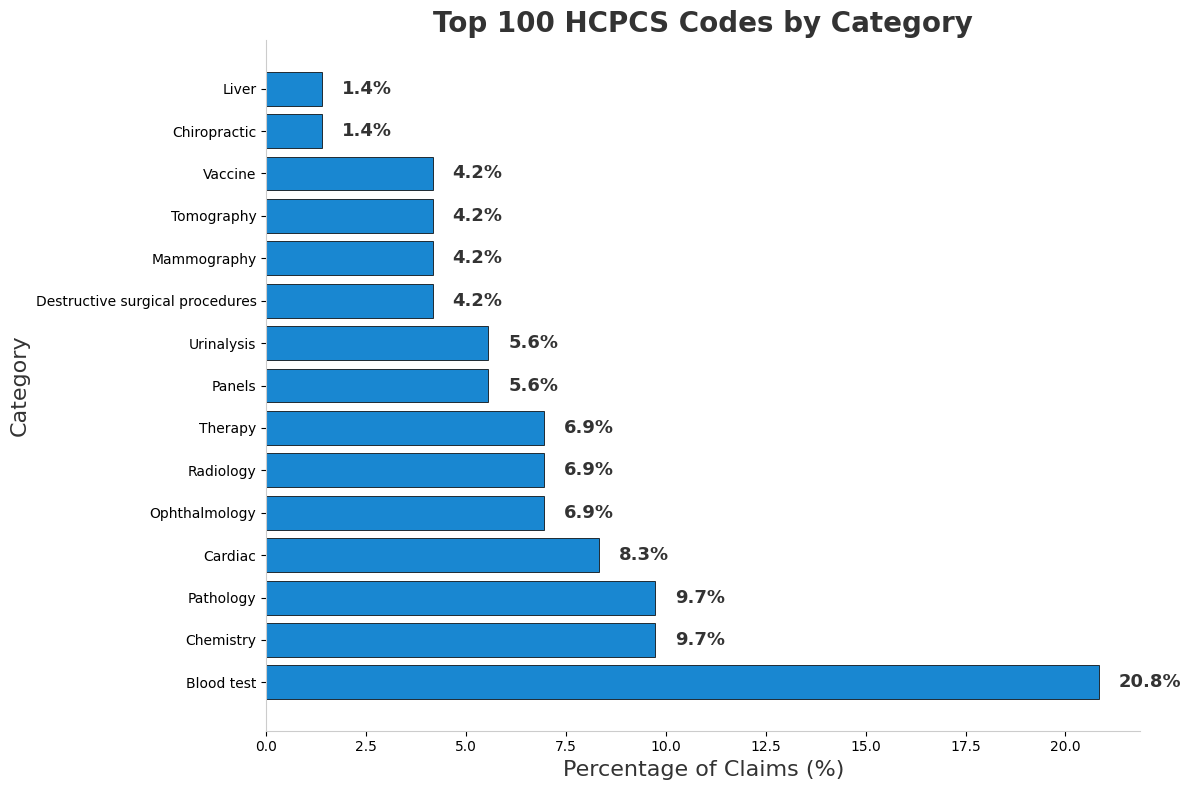

In [244]:
import matplotlib.pyplot as plt
#use percentage of claims by category
category_count_df = hcpcs_code_100_df.groupby('category').agg(
    category_count=('hcpcs_code', 'count')
).sort_values('category_count', ascending=False)
category_count_df['category_pct'] = category_count_df['category_count']/category_count_df['category_count'].sum()*100

fig, ax = plt.subplots(figsize=(12, 8))

# Professional color palette
color = '#007acc'

# Plotting the horizontal bar chart with polished aesthetics
ax.barh(
    category_count_df.index, 
    category_count_df['category_pct'], 
    color=color, 
    edgecolor='black', 
    linewidth=0.6, 
    alpha=0.9
)

# Adding title and labels with refined font styles
ax.set_title('Top 100 HCPCS Codes by Category', fontsize=20, fontweight='bold', color='#333333')
ax.set_xlabel('Percentage of Claims (%)', fontsize=16, color='#333333')
ax.set_ylabel('Category', fontsize=16, color='#333333')

# Displaying percentage
for i in ax.patches:
    ax.text(
        i.get_width() + 0.5, 
        i.get_y() + i.get_height() / 2, 
        f'{i.get_width():.1f}%', 
        ha='left', 
        va='center', 
        fontsize=13, 
        color='#333333', 
        weight='bold'
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Adjust layout and display
plt.tight_layout()
plt.show()


***Summary of the above figure***
- Based on the above figure, we can observe the distribution of claim categories and their respective percentages of the total claims. The Cardiac category accounts for 8.33% of the total claims, indicating a great demand for cardiac services. Based on this fact, we can focus on targeted marketing strategies that focuses on cardiovac health. and emphasize the importance regualr check-ups. 

In [363]:
category_count_df

,category_count,category_pct
category,,
Blood test,15,20.833333
Chemistry,7,9.722222
Pathology,7,9.722222
Cardiac,6,8.333333
Ophthalmology,5,6.944444
Radiology,5,6.944444
Therapy,5,6.944444
Panels,4,5.555556
Urinalysis,4,5.555556


In [173]:
hcpcs_code_100_cardiac_df.head(100)

,hcpcs_code,description,category
0,36415,Venous Procedures,Cardiac
9,93010,"Electrocardiogram, routine ECG with at least 1...",Cardiac
12,93000,"Electrocardiogram, routine ECG with at least 1...",Cardiac
20,93306,"Echocardiography, transthoracic, real-time wit...",Cardiac
27,93005,"Electrocardiogram, routine ECG with at least 1...",Cardiac
51,78452,"Myocardial perfusion imaging, tomographic (SPE...",Cardiac


In [176]:
cardiac_claims_df = medicare_df.loc[
    medicare_df.hcpcs_code.isin(hcpcs_code_100_cardiac_df.hcpcs_code)
]
non_cardiac_claims_df = medicare_df.loc[
    ~medicare_df.hcpcs_code.isin(hcpcs_code_100_cardiac_df.hcpcs_code)
]
#combine the two dataframes
cardiac_vs_non_cardiac_medicare_df = pd.concat([cardiac_claims_df, non_cardiac_claims_df])

In [ ]:

#check for null values
cardiac_vs_non_cardiac_medicare_df.isnull().sum()

#check for duplicates
cardiac_vs_non_cardiac_medicare_df.duplicated().sum()


0

In [ ]:

#make sure that data contains only years 2016, 2017, 2018
import matplotlib.pyplot as plt
import seaborn as sns

#year should only contain 2016, 2017, 2018
cardiac_claims_df = cardiac_claims_df[cardiac_claims_df['claim_year'].isin(['2016', '2017', '2018'])]
non_cardiac_claims_df = non_cardiac_claims_df[non_cardiac_claims_df['claim_year'].isin(['2016', '2017', '2018'])]

cardiac_claims_yearly_df = cardiac_claims_df.groupby(['claim_year']).agg(
    cardiac_claims_cnt=('claim_id', 'nunique')
).reset_index()
cardiac_claims_yearly_df['cardiac_claims_pct'] = cardiac_claims_yearly_df['cardiac_claims_cnt']/cardiac_claims_yearly_df['cardiac_claims_cnt'].sum()*100

non_cardiac_claims_yearly_df = non_cardiac_claims_df.groupby(['claim_year']).agg(
    non_cardiac_claims_cnt=('claim_id', 'nunique')
).reset_index()

non_cardiac_claims_yearly_df['non_cardiac_claims_pct'] = non_cardiac_claims_yearly_df['non_cardiac_claims_cnt']/non_cardiac_claims_yearly_df['non_cardiac_claims_cnt'].sum()*100

cardiac_vs_non_cardiac_medicare_df = pd.merge(
    cardiac_claims_yearly_df,
    non_cardiac_claims_yearly_df,
    on='claim_year', how='outer'
).fillna(0)


**Data Quality Check : check that the years in non-cardiac and cardiac claims are within the range of 2016-2018.**

In [ ]:
# Check the unique years after filtering
print("\nUnique 'claim_year's in cardiac_claims_df after filtering:")
print(cardiac_claims_df['claim_year'].unique())

print("\nUnique 'claim_year's in non_cardiac_claims_df after filtering:")
print(non_cardiac_claims_df['claim_year'].unique())


Unique 'claim_year's in cardiac_claims_df after filtering:
['2017' '2016' '2018']

Unique 'claim_year's in non_cardiac_claims_df after filtering:
['2018' '2017' '2016']


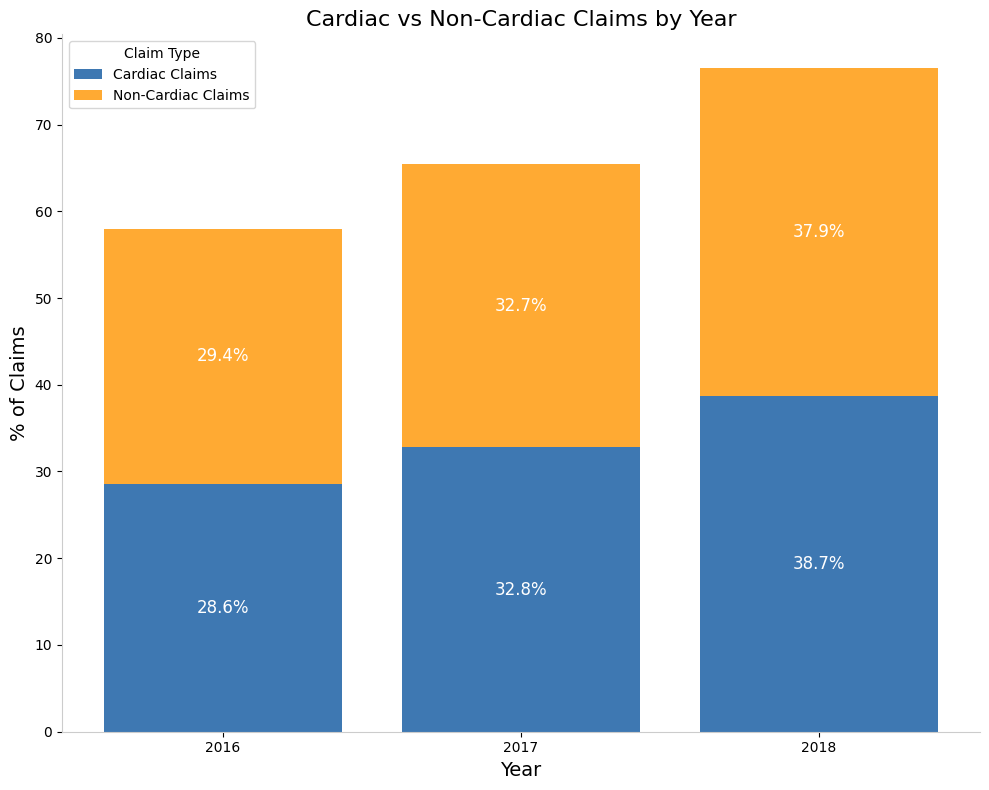

In [ ]:
# Plot the stacked bar chart
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#1f77b4', '#ff7f0e']
colors = ['#3E78B2', '#FFAA33']

# Plotting the cardiac and non-cardiac claims as stacked bars
ax.bar(
    cardiac_vs_non_cardiac_medicare_df['claim_year'], 
    cardiac_vs_non_cardiac_medicare_df['cardiac_claims_pct'], 
    label='Cardiac Claims', 
    color=colors[0]
)
ax.bar(
    cardiac_vs_non_cardiac_medicare_df['claim_year'], 
    cardiac_vs_non_cardiac_medicare_df['non_cardiac_claims_pct'], 
    bottom=cardiac_vs_non_cardiac_medicare_df['cardiac_claims_pct'], 
    label='Non-Cardiac Claims', 
    color=colors[1]
)

plt.title('Cardiac vs Non-Cardiac Claims by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('% of Claims', fontsize=14)

# Display percentages on each bar
for i in range(len(cardiac_vs_non_cardiac_medicare_df)):
    cardiac_pct = cardiac_vs_non_cardiac_medicare_df['cardiac_claims_pct'][i]
    non_cardiac_pct = cardiac_vs_non_cardiac_medicare_df['non_cardiac_claims_pct'][i]
    year = cardiac_vs_non_cardiac_medicare_df['claim_year'][i]
    
    #
    ax.text(
        year, cardiac_pct / 2, f'{cardiac_pct:.1f}%', ha='center', va='center', color='white', fontsize=12
    )
  
    ax.text(
        year, cardiac_pct + non_cardiac_pct / 2, f'{non_cardiac_pct:.1f}%', ha='center', va='center', color='white', fontsize=12
    )

plt.legend(title="Claim Type", loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

plt.tight_layout()
plt.show()

In [371]:
cardiac_vs_non_cardiac_medicare_df.head(100)

,claim_year,cardiac_claims_cnt,cardiac_claims_pct,non_cardiac_claims_cnt,non_cardiac_claims_pct,total_pct
0,2016,3921,28.557902,27253,29.410241,57.968144
1,2017,4500,32.774945,30290,32.687638,65.462584
2,2018,5309,38.667152,35122,37.902121,76.569273


***Explanation and Observation***:
- The proportion of cardiac claims is increasing at a faster rate compared to non-cardiac claims.
- The total percentage of both cardiac and non-cardiac claims is increasing over the years.
- The significant increase in the percentage of cardiac claims indicates a higher demand for cardiac services.
- There may be a rising incidence of cardiovacs in the patient due to factors like aging, lifestyle changes, or increased awareness and diagnosis.
- Revenue growth potential -- The increasing claims hints a potential revenue growth, but also the need to manage increased operational costs.




## Q2. Evaluate the HCP behavior in context of claim volume from 2016-2018. How many HCPs are submitting 1 CVM claim; how many HCPs are associated with more than 10 claims, etc.? Once you perform this analysis, explain how this trend can influence the sales force deployment. That is, how would you segment the HCPs and how would you allocate In-Person (sales force) vs Non-Personal Promotions (NPP, i.e. Emails, Social Media, Digital etc.) efforts?

***Data Quality Checks***

In [359]:
# Check for missing 'npi_id' values
missing_npi_ids = cardiac_claims_df['npi_id'].isnull().sum()
print("\nNumber of missing 'npi_id' values:", missing_npi_ids)

# Examine 'npi_id' values
print("\nSample 'npi_id' values:")
print(cardiac_claims_df['npi_id'].dropna().head())



Number of missing 'npi_id' values: 3134

Sample 'npi_id' values:
165    1.114950e+09
210    1.376724e+09
215    1.013975e+09
220    1.528197e+09
237    1.184665e+09
Name: npi_id, dtype: float64


In [208]:
cardiac_claims_df

,claim_year,npi_id,cardiac_claims_cnt,claim_count_category
0,2018,1.538145e+09,138,10+
1,2018,1.619913e+09,97,10+
2,2018,1.063497e+09,73,10+
3,2018,1.659352e+09,65,10+
4,2018,1.932184e+09,48,10+
5,2018,1.326105e+09,48,10+
6,2018,1.891732e+09,47,10+
7,2018,1.619972e+09,44,10+
8,2018,1.932166e+09,43,10+
9,2018,1.518903e+09,42,10+


In [211]:
#drop the cardiac records with no npid id for provider/prescriber
cardiac_claims_df = cardiac_claims_df.dropna(subset=['npi_id'])
#Get the claim year for each claim
cardiac_claims_df['claim_year'] = pd.to_datetime(
    cardiac_claims_df['claim_year']
).dt.strftime('%Y')

#Count the CVM claims on a year & provider level
cardiac_claims_yearly_provider_df = cardiac_claims_df.groupby(['claim_year', 'npi_id']).agg(
    cardiac_claims_cnt=('npi_id', 'nunique')
).reset_index()



In [230]:
# Count the number of unique providers for each year
provider_count_per_year = df[df['claim_year'].isin([2018])].groupby('claim_year')['npi_id'].nunique()
# Display the result
print(provider_count_per_year)



claim_year
2018    21200
Name: npi_id, dtype: int64


In [372]:
df.head(100)

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost,patient_birth_date,patient_gender,claim_year,patient_age
165,104681,10174,1114949963,2016-11-19,36415,J441,71.49,1954-04-13,M,2016,62
210,105873,10159,1376723759,2016-02-17,36415,I509,16.72,1921-11-14,M,2016,95
215,106316,10205,1013975010,2017-05-16,93306,I350,730.09,1944-02-01,M,2017,73
220,106765,1320,1528196656,2018-06-26,36415,I10,83.38,1928-10-11,F,2018,90
237,108354,10535,1184664831,2016-09-23,36415,E785,38.40,1944-09-28,M,2016,72
...,...,...,...,...,...,...,...,...,...,...,...
3189,184006,10200,1538126966,2017-01-09,36415,Z7901,11.16,1931-04-20,M,2017,86
3245,185655,12876,1700856200,2018-02-22,93306,I509,1627.14,1929-05-26,F,2018,89
3250,185655,12876,1700856200,2018-02-22,93005,I509,1627.14,1929-05-26,F,2018,89
3276,186450,10485,1376595082,2017-07-31,36415,C61,28.77,1947-07-01,M,2017,70


/var/folders/7j/4wqs2nqj75j1qj2l976vhgmh0000gn/T/ipykernel_16482/4002818842.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['npi_id'] = df['npi_id'].astype(int)
/var/folders/7j/4wqs2nqj75j1qj2l976vhgmh0000gn/T/ipykernel_16482/4002818842.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['claim_year'] = df['claim_year'].astype(int)
/var/folders/7j/4wqs2nqj75j1qj2l976vhgmh0000gn/T/ipykernel_16482/4002818842.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to Tr

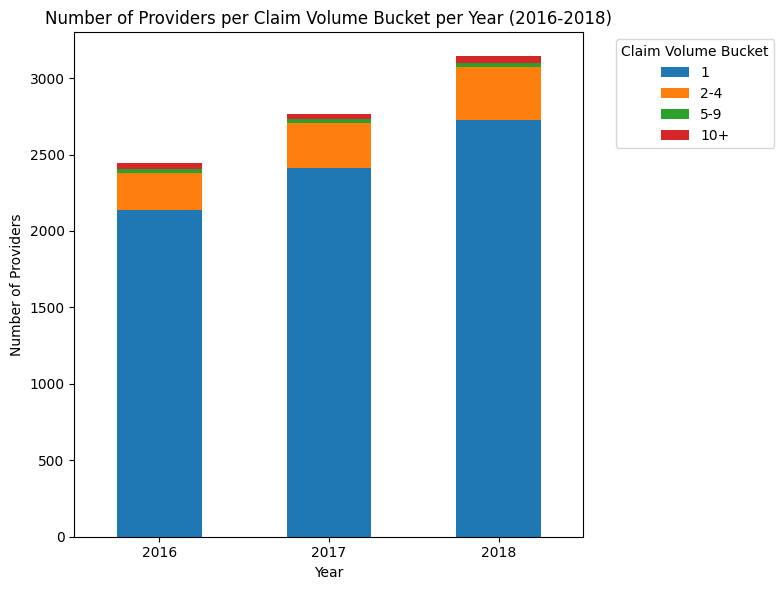

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#Drop records with no NPI ID for provider/prescriber
df = cardiac_claims_df.dropna(subset=['npi_id'])

# Convert 'npi_id
df['npi_id'] = df['npi_id'].astype(int)

# Ensure 'claim_year' is integer
df['claim_year'] = df['claim_year'].astype(int)

#Count the CVM claims on a year & provider level
claim_counts = df.groupby(['npi_id', 'claim_year']).size().reset_index(name='num_claims')

# Categorize the number of claims into different buckets
bins = [0, 1, 4, 9, float('inf')]
labels = ['1', '2-4', '5-9', '10+']
claim_counts['bucket'] = pd.cut(claim_counts['num_claims'], bins=bins, labels=labels)

# Get number of providers on a bucket & year level
providers_per_bucket = claim_counts.groupby(['claim_year', 'bucket'])['npi_id'].nunique().reset_index(name='num_providers')

# Pivot the data
pivot_table = providers_per_bucket.pivot(index='claim_year', columns='bucket', values='num_providers').fillna(0)

#the bucket columns are in the correct order (data quality)
pivot_table = pivot_table.reindex(columns=labels, fill_value=0)

#Create the stacked bar chart
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(8, 6))
ax.set_xlabel('Year')
ax.set_ylabel('Number of Providers')
ax.set_title('Number of Providers per Claim Volume Bucket per Year (2016-2018)')
plt.xticks(rotation=0)
plt.legend(title='Claim Volume Bucket', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


***Explanation and Observation***:
 - The majority of HCPs fall into the 1-claim bucket each year,which shows us that that most providers submit only one cardiovac claim per year.
 - There is a smaller but noticeable portion of HCPs in the 2-4 claims bucket.
 - The 5-9 claims and 10+ claims categories have a relatively small number of HCPs, demonstrating that a high claim concentration in a few providers.

- Based on the claim volume, we can segment HCPs and recommend sales strategies for each segment:
  - Allocate direct sales efforts to build relationships, provide detailed product information,for HCPs with 10+ claims. They should have regular in-person visits because of their high volume of claims and potential influence within the market.
  - 5-9 Claims bucket, a hyrid approach of in-person and non-personal promotions would be ideal, less freqeuntly than the 10+ claims bucket.
  - Lower HCP( 2 - 4 claims). The best strategy here would be to focus on digital and remote communication such as emails and social media to keep them aware of certain offerings without having to invest high sales force resources.
  - 1 Claim buket: This group represents the largest volume of providers but submits only one CVM claim yearly. I think because of their low engagement, investing in an in-person sales force is unlikely to yield significant returns. I would focus solely on non-personal promotions to reach this group(like ditial channels.)





## Q3. Evaluate the Patient Age demographics in the context of claim volume from 2016-2018. Bucket the patients into groups based on their age and explain the trends. How would you position the Marketing Budgets and the Promotions with respect to the changing landscape of the CVM claims and the respective patient segments? 

In [360]:
#count the CVM claims on a year & patient age level
cardiac_claims_yearly_age_df = cardiac_claims_df.groupby(['claim_year', 'patient_age']).agg(
    cardiac_claims_cnt=('claim_id', 'nunique')
).reset_index()
#Categorize the patient age into different buckets: 18-59, 60-69, 70-79, 80-100
cardiac_claims_yearly_age_df['patient_age_category'] = pd.cut(
    cardiac_claims_yearly_age_df['patient_age'],
    bins=[18, 60, 70, 80, 100],
    labels=['18-59', '60-69', '70-79', '80-100']
)
#Find the number of claims on a bucket & year level

cardiac_claims_yearly_age_category_df = cardiac_claims_yearly_age_df.groupby(
    ['claim_year', 'patient_age_category']
).agg(
    cardiac_claims_cnt=('cardiac_claims_cnt', 'sum')
).reset_index()

#view
cardiac_claims_yearly_age_category_df.head(10000)


/var/folders/7j/4wqs2nqj75j1qj2l976vhgmh0000gn/T/ipykernel_16482/98691083.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cardiac_claims_yearly_age_category_df = cardiac_claims_yearly_age_df.groupby(


,claim_year,patient_age_category,cardiac_claims_cnt
0,2016,18-59,450
1,2016,60-69,1459
2,2016,70-79,1097
3,2016,80-100,915
4,2017,18-59,497
5,2017,60-69,1685
6,2017,70-79,1377
7,2017,80-100,941
8,2018,18-59,491
9,2018,60-69,1885


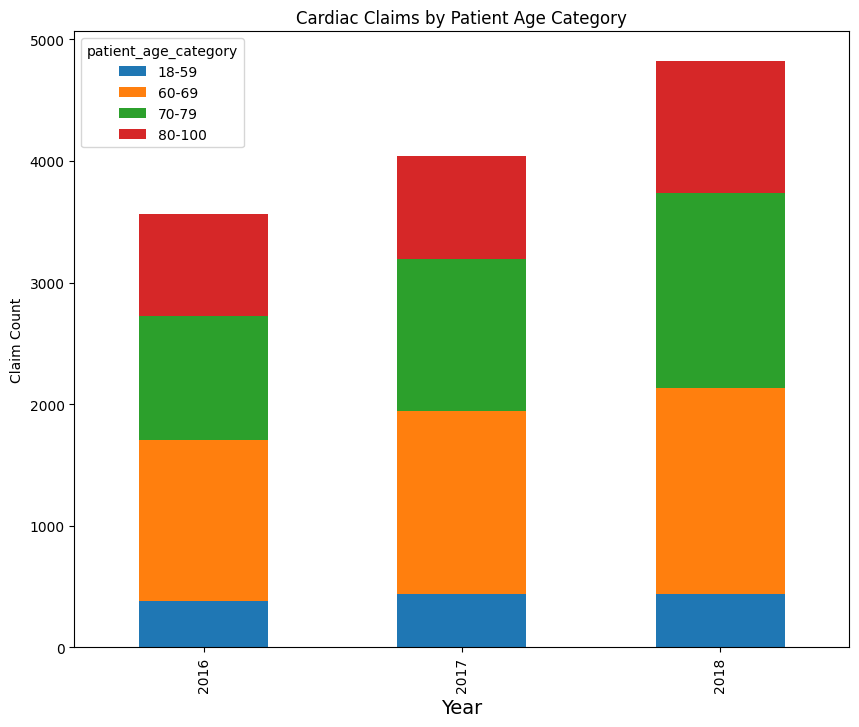

In [224]:
#Pivot to have the buckets as columns, the claim count as values, and the year as index
cardiac_claims_yearly_age_category_pivot_df = cardiac_claims_yearly_age_category_df.pivot(
    index='claim_year', columns='patient_age_category', values='cardiac_claims_cnt'
).fillna(0)

#Create the stacked bar chart
cardiac_claims_yearly_age_category_pivot_df.plot(
    kind='bar', stacked=True, figsize=(10, 8)
)
# Removing unnecessary spines and adding a subtle grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', color='#CCCCCC', alpha=0.6)
#label the chart
plt.title('Cardiac Claims by Patient Age Category', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.title('Cardiac Claims by Patient Age Category')
plt.xlabel('Year')
plt.ylabel('Claim Count')
plt.show()



***Explanation***
**Observation**

- The 60-69 and 70-79 age groups show the most significant and consistent growth in cardiac claims.**
- 80-100 age group has a substantial increase in 2018.
- 18-59 age group shows modest growth, with a plateau between 2017 and 2018.

**Recommendation**
- To allocate marketing budget:
     - My primary focus would be 60-69 and 70-79 age groups, as they represent the largest increases in cardiac claims.
     - Secondayr focus would be 80-100 age groups, as tthey show a shar increase in 2018.  I would like to dedicate resources to understand this sudden growth and tailor promotions accordingly.
- I would also trailor promotions to patient segmenets:
  - For Ages 60-79: I would allocate more budget to in-person promotions, as these age groups show the most significant growth in cardiac claims.
  - For Ages 80-100: I would make sure that marketing strategies are accessible to them. For instance, by using traditional media and in-person outreach, as this group may be less digitally engaged.

